In [21]:
from services import ParserService, SimulationService
from schemas import AdviserConfig, Profile, RecurringCashFlow, ExtractionSchema

from simulation_engine.common.types import SimulationPortfolioWeights

from llama_cloud_services import LlamaExtract
from scipy.optimize import minimize

import datetime
import numpy as np

In [3]:
adviser_config = AdviserConfig(
    risk_allocation_map={1: 0.3, 2: 0.5, 3: 0.6, 4: 0.8, 5: 0.9},
    inflation=0.02,
    asset_costs={"stocks": 0.001, "bonds": 0.001, "cash": 0.001},
    expected_returns={"stocks": 0.08, "bonds": 0.04, "cash": 0.02},
    number_of_simulations=1000
)


In [4]:

profile = Profile(
    id=1, 
    name='Andrea', 
    age=42.0, 
    retirement_age=65.0, 
    plan_end_age=100, 
    current_portfolio_value=120000.0
)

In [5]:

cash_flows = [
    RecurringCashFlow(
        profile=1, 
        name='Salary', 
        amount=7916.666666666667, 
        start_date=datetime.date(2025, 10, 31), 
        end_date=datetime.date(2048, 10, 31)
    ),
    RecurringCashFlow(
        profile=1, 
        name='Rental income', 
        amount=1000.0, 
        start_date=datetime.date(2025, 10, 31), 
        end_date=datetime.date(2048, 10, 31)
    ),
    RecurringCashFlow(
        profile=1, 
        name='Total monthly expenses', 
        amount=-4500.0, 
        start_date=datetime.date(2025, 10, 31), 
        end_date=datetime.date(2083, 10, 31)
    )
]

In [ ]:


bounds = [(0, 1) for _ in range(len(start_weights))]

In [ ]:
def run_simulation_with_allocations(weights):

    changes = np.concatenate([[True], weights[1:] != weights[:-1]])
    change_indices = np.where(changes)[0]

    sim_weights = []
    for idx in change_indices:
        sim_weights.append(SimulationPortfolioWeights(
            step=float(idx),
            stocks=float(weights[idx]),
            bonds=float(1.0 - weights[idx])
        ))

    simulation_service = SimulationService(
        profile=profile, 
        cash_flows=cash_flows, 
        adviser_config=adviser_config, 
        weights=sim_weights
    )

    result = simulation_service.simulate()
    return result


In [ ]:

def direction_penalty(allocations: np.ndarray) -> float:
    changes = np.diff(allocations)
    increases = np.clip(changes, 0.0, None)
    penalty = 200.0 * float(np.sum(increases ** 2))
    return penalty


In [ ]:
### Objective function ###

bounds = [(0, 1) for _ in range(len(start_weights))]

def objective(allocations):
    # a = project_allocations(allocations)
    result = run_simulation_with_allocations(allocations)
    destitution = result.destitution_area

    penalty = direction_penalty(allocations)

    return destitution + penalty


In [54]:
res.x

array([0.8984477 , 0.88698685, 0.87747702, 0.86795771, 0.85844788,
       0.84602099, 0.83731836, 0.82505031, 0.81358954, 0.80407962,
       0.79553582, 0.78505048, 0.77456514, 0.76310437, 0.75261895,
       0.74116757, 0.73068222, 0.72116292, 0.70971154, 0.69825069,
       0.6906824 , 0.67825551, 0.66777017, 0.65728483, 0.64874103,
       0.63825569, 0.6248533 , 0.61728501, 0.60679966, 0.59437277,
       0.58388743, 0.57242658, 0.56485829, 0.55437295, 0.54194606,
       0.53340227, 0.5219415 , 0.51243158, 0.50097073, 0.48951935,
       0.4780585 , 0.46951471, 0.45806332, 0.44951953, 0.43709264,
       0.4266073 , 0.41612196, 0.40757816, 0.39611731, 0.38660747,
       0.37612213, 0.36563679, 0.3532099 , 0.34466611, 0.33320526,
       0.32369542, 0.31126853, 0.3017526 ])

In [52]:
res = minimize(
    fun=objective, 
    x0=start_weights,
    method='SLSQP',
    bounds=bounds
)

allocations:  [0.9        0.88947368 0.87894737 0.86842105 0.85789474 0.84736842
 0.83684211 0.82631579 0.81578947 0.80526316 0.79473684 0.78421053
 0.77368421 0.76315789 0.75263158 0.74210526 0.73157895 0.72105263
 0.71052632 0.7        0.68947368 0.67894737 0.66842105 0.65789474
 0.64736842 0.63684211 0.62631579 0.61578947 0.60526316 0.59473684
 0.58421053 0.57368421 0.56315789 0.55263158 0.54210526 0.53157895
 0.52105263 0.51052632 0.5        0.48947368 0.47894737 0.46842105
 0.45789474 0.44736842 0.43684211 0.42631579 0.41578947 0.40526316
 0.39473684 0.38421053 0.37368421 0.36315789 0.35263158 0.34210526
 0.33157895 0.32105263 0.31052632 0.3       ]
sim_weights:  [SimulationPortfolioWeights(step=0.0, stocks=0.9, bonds=0.09999999999999998), SimulationPortfolioWeights(step=1.0, stocks=0.8894736842105263, bonds=0.1105263157894737), SimulationPortfolioWeights(step=2.0, stocks=0.8789473684210527, bonds=0.1210526315789473), SimulationPortfolioWeights(step=3.0, stocks=0.868421052631579, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144428.6875529056, 179660.8526363595, 211777.3712492608, 251198.42431894757, 288674.73600133846, 336598.2469217112, 366215.71318237035, 397676.9099190544, 451438.992798592, 494427.8534127898, 534007.3326885831, 578518.5576509861, 629053.4323138644, 663635.4454796034, 707081.920633608, 756547.1125630143, 821460.5164570846, 862970.1468223744, 916415.8331230369, 966189.4643265718, 1005413.3421892045, 1034401.6162840164, 1100499.2613702058, 1061091.1098442515, 996863.8980664558, 976315.8719077393, 951508.1637650577, 858882.6852357885, 854850.4983837585, 804889.8877966669, 758939.206198671, 723801.7849242905, 698117.4811805973, 659097.2756909317, 618159.7000643284, 558413.3712947892, 527172.132106142, 455017.765734244, 412565.50304224086, 345410.77571993554, 292226.0203958217, 251986.61697174353, 213130.56847263378, 164480.20252369123, 113687.67539061733, 66037.14292573408, 1984.2743634110893, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143500.69618319647, 178455.65526196558, 217602.23808494126, 259752.57177804344, 289987.2089721737, 323792.1887258305, 369746.965240688, 406345.7780309294, 444541.01336181903, 478824.07035002165, 530037.9528519544, 577373.4613415435, 633092.7550951338, 659811.6551466982, 674324.6701257577, 737058.3967185194, 769097.5251902777, 821924.1111554385, 841603.042635956, 907744.1357518353, 965703.9706674545, 1014475.774936838, 1098062.172399213, 994257.5255419813, 934017.3985044563, 910531.6506839672, 894893.5988979364, 858977.2717944746, 825361.1189968593, 762904.7674042415, 701136.9878016775, 691978.1005716246, 610728.6242022652, 582827.3480664106, 560419.6498107904, 521971.57788127335, 463111.1191470904, 419590.0538615991, 373850.74746345315, 313105.283733163, 263266.67003980704, 208064.9572439334, 159294.44986687807, 114309.61020119902, 69163.18650263594, 19962.34596353365, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144785.20542077677, 178359.88741297132, 219371.56935535607, 253059.12711874724, 284053.61896983004, 321979.6678772827, 348051.1427421755, 390562.64347859344, 426226.83618396946, 475510.05445864756, 521959.17717105546, 579878.721501701, 607414.3495969119, 656006.190816095, 700282.4525042863, 731186.0734917313, 749019.9448695515, 808251.9162063154, 855264.0127983942, 909642.7256702182, 959698.2492416216, 1027539.9727837294, 1126356.475911306, 1049143.3480797487, 1032826.3519786733, 986581.9024046178, 919876.2067508459, 890094.5901622296, 847463.2399855256, 834187.6267782861, 779518.4528438243, 738472.9732301797, 689597.1588359877, 664244.9627952869, 619309.6986091592, 603284.3600988886, 541110.2627947672, 519123.7537997934, 452844.3586554315, 409584.72197182477, 380061.2581441617, 312596.7061608757, 269506.86001412675, 227337.00056906827, 176567.65767677236, 100648.73984517982, 48428.90395203198, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142927.23822713824, 181741.52063374373, 217949.7717484264, 251050.40296080167, 287837.07814123435, 314665.547268884, 349890.63130586536, 395907.4612070124, 445225.67790382827, 486666.3931835931, 520807.1729022652, 561143.2026166687, 593538.6833968869, 643745.1805316532, 711060.6751742287, 738950.356531043, 812889.6599530635, 833759.320237726, 890575.093329083, 929272.0356010341, 999578.7707312921, 1063454.513830658, 1111842.3629417429, 1045005.1704366358, 1004879.5795675663, 965400.6659837244, 921428.1693140317, 869562.3478603581, 833667.1716537528, 798352.4609043094, 739605.3238491904, 744193.2915897805, 671209.5822546025, 624113.1343075472, 594624.1767419485, 524146.0424366446, 466219.1780040411, 455796.09776335355, 432903.1683015659, 369777.79537044035, 337066.24936128635, 286912.38902239717, 259391.39466697758, 194655.10738641792, 149231.20084334223, 90656.56454721118, 41562.51041778738, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145199.1543591656, 183973.9341324934, 214862.68189355105, 256581.82717281932, 288383.3116423628, 322155.5908151402, 372542.2175293322, 395741.20352631854, 452336.1955851738, 487769.37727909215, 526752.7320546778, 562883.2231942374, 603705.4183991282, 646421.1717931366, 684703.2174755012, 737378.4483499671, 763477.9533045175, 815200.9999038698, 843398.1231407047, 900754.0873217197, 980106.3865136427, 999503.5277429026, 1044828.2682083017, 1005442.3693732783, 952486.7126481081, 917510.9265302675, 894627.8659445526, 820290.984343807, 783763.3481794466, 799545.1268149505, 720353.5018390112, 663990.9601377407, 605417.7176375227, 572031.4776004729, 579006.8559782333, 532218.4999802236, 485587.5345894, 460197.94722112175, 406901.6979028228, 361113.78740632953, 329954.24541832594, 277378.06851997366, 230398.39475335513, 183156.74554961355, 131647.42598858, 89128.64498741424, 32873.19250075657, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 146470.5947922319, 181350.6253749108, 211842.19281005755, 251106.32372782295, 291396.8597088283, 328546.68636840815, 366038.82291452686, 400213.9857354804, 437911.150167375, 475137.9099576746, 527135.6588777276, 578299.5027179634, 620517.686173788, 669574.7088774001, 706633.0547777782, 755657.1894889601, 800762.0127711494, 847564.9178524275, 899356.3635697024, 937293.6061112668, 983576.0539576391, 1052900.8018670846, 1117392.9820691666, 1053898.4814093278, 1024366.373435766, 954404.3550877057, 927506.183060967, 863382.0936410378, 811758.0125184833, 773083.6912262021, 768406.5316886121, 732889.5074055078, 665964.2431936965, 632973.0857133497, 597492.2075849833, 559686.2975226832, 489939.29079601425, 457757.210149548, 420581.7399086831, 402297.43161762814, 367942.9065058113, 304484.2880355894, 260293.6094423408, 215081.62149877287, 173549.09688870667, 116272.71278666327, 62455.962810139405, 8158.975072146581, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144228.41092876968, 181274.57738810685, 216377.70535857344, 248749.46290753674, 294322.22138779244, 333978.51181928656, 376421.8392763943, 405331.70571131486, 454115.47457917524, 499079.223329968, 528964.7727690261, 574869.3192210636, 601537.0034791285, 654366.3898601047, 679043.7602578487, 754260.2720249146, 793904.2027862229, 863832.3194956852, 898049.7227029349, 952813.127883715, 1011318.2209295586, 1055577.7951312824, 1084643.9889064534, 1017693.1741686972, 969308.0876077005, 939798.3200907604, 916952.8929043773, 842680.0532151181, 792223.5698360449, 750563.7787643814, 722447.5386335221, 691531.7965560373, 629403.5618605263, 585156.9101734491, 565007.4651789796, 522275.9657463858, 477097.74422695005, 453316.6550702292, 398987.79105383885, 351953.804394943, 323937.0868008954, 279032.5409891038, 229184.88439737028, 179630.07189042165, 142400.64730534697, 75161.59624529828, 28469.319220723602, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144303.0472502179, 180214.2123896525, 221640.75577853603, 255020.4494500606, 294599.7256131151, 324764.25928719394, 373062.4639048318, 401484.9600219455, 446371.9694810838, 483809.85933630296, 527390.2459081032, 565381.0193014275, 611174.7360630521, 661102.0002701133, 714123.000206421, 744544.0515283608, 780980.6381825712, 814065.5748921201, 878937.9543181831, 919830.4653517996, 978892.5972175795, 991322.6954743579, 1043201.0620520205, 1006033.4099539005, 954625.5151846299, 881071.2181915725, 870987.6282679817, 857432.4890609696, 805716.6005901538, 769851.4923001956, 715200.285763509, 667259.5325900288, 611305.7177254154, 585873.7797615882, 539397.5788193912, 527068.3888283125, 470190.3912543613, 415658.6435279487, 364327.3042282707, 318549.8785189309, 272364.1775683539, 233150.22542716956, 197121.78361212285, 138529.84274271195, 88599.03447767314, 35349.453019350134, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143763.80259348475, 179307.12817049172, 220934.465930035, 256230.6364885474, 298772.88498777046, 323411.4057285494, 373530.08180074056, 405204.8936673105, 446669.5244693345, 487120.1455527974, 516297.20045174717, 576307.3139912634, 608916.0092073682, 650932.2812764967, 691606.6320519475, 743431.5204415037, 796108.0172704208, 836565.0302945093, 896999.970952449, 949941.4605015226, 1003132.8415631354, 1056907.3962206484, 1085424.1139459612, 1048081.1366677769, 1006471.5455752286, 915837.3631497844, 884431.6542416317, 846413.4200700861, 825835.6535791436, 762336.6198359573, 725776.9011719207, 734940.1409425447, 669018.4186976308, 626859.5392576203, 583801.8838194504, 550043.3047467652, 520151.9951002962, 449619.73931447655, 430167.4148485482, 396851.9309746771, 352612.9745131833, 320592.03763689066, 241338.341030104, 218006.05207195025, 180722.33529438826, 126161.76862409608, 82296.30565832593, 29023.092621875923, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142590.76353047896, 181009.24146585952, 214952.00593826728, 250621.55356360736, 289294.56941300724, 326940.3043316952, 369038.70757676463, 405538.20291487855, 446113.47850624373, 494461.5036870346, 532233.1339089833, 577696.3326943085, 613091.5440545594, 642614.2892032341, 683839.6631628375, 732911.3375364365, 790194.4126038144, 846399.7148940287, 891843.3205630737, 906239.0583557335, 952587.7414951286, 1012646.5011679622, 1069875.2953042632, 1021907.5559010383, 966903.718404633, 947865.0360956565, 884230.3515137654, 828634.8873354483, 847009.2136208741, 792740.453482396, 741032.3065535416, 670333.926706962, 618534.2822860886, 569025.677069328, 541605.5358761147, 492106.7833247163, 448747.6878680441, 393986.75005468127, 361391.6235014241, 321717.54407181835, 296427.45321929397, 256786.76679647694, 203252.69682468794, 152146.2050785682, 114810.11654545239, 63526.84353086022, 4533.216122976366, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142859.53924803366, 183615.75783108547, 218349.12244421276, 260165.84190148592, 296319.1494083677, 325813.80484215874, 370725.0903732308, 407908.2425084003, 449455.760643652, 491812.9047435406, 532119.9838905262, 574551.711211741, 594672.0193304933, 643294.1535632287, 695784.991096385, 737294.1665230661, 759722.0082555135, 824363.0722396859, 870989.223202766, 952567.7738052527, 965068.7448270001, 1034947.6990385992, 1055126.9831756786, 1027046.3771579668, 982461.2299370157, 962202.071484254, 920981.8971797265, 916453.0469081412, 894224.9332323424, 830326.3883762638, 762853.3551474412, 704790.5765502895, 677553.9410389655, 635482.9685848402, 601398.2500961745, 580939.792159041, 558816.7519030984, 503100.8034174464, 443999.6472655821, 413909.9055315433, 362361.9762454456, 344028.3096649973, 299309.47207407095, 246097.28194198976, 218489.58830065242, 169489.6810658388, 126437.66124557286, 80432.42241103094, 17836.40776181751, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145860.57767584713, 184548.5229541869, 218089.3777572672, 258500.1480390721, 285289.55801475607, 332553.8376931214, 377142.62074445473, 411444.6513862916, 462997.15312233317, 486531.16750847065, 530307.2494735119, 576073.9849635338, 594240.3446434202, 652313.777353797, 708301.1311942595, 767704.4042686826, 792256.7102835956, 832529.8991285358, 851504.5980889893, 896014.4853637688, 945816.2891799223, 995219.469952501, 1098238.9554605482, 1038913.3659207253, 1009837.6741490897, 963406.6261174232, 909524.3679660731, 871790.6847604673, 839541.7186476566, 793004.0716140545, 778929.3137840591, 701743.442701202, 666725.2318918719, 650798.5115753978, 602405.2778721338, 590744.2125061649, 546741.8997188029, 532256.0473918553, 500110.30050921533, 448050.3004161311, 378204.48960263823, 321941.4929728966, 298430.8571355516, 267727.60260504246, 197223.91557293126, 152490.46210436226, 107632.84842554061, 62191.900739027406, 1

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142487.87177255636, 180026.231934682, 213246.5706319419, 245609.43422549803, 287477.2460594515, 326920.7666323185, 356489.98922038387, 396988.42872186255, 430931.9958203725, 464724.4476909167, 509275.7769405928, 557498.6408082434, 611470.2502640176, 654711.3361209694, 694513.6204875214, 740161.1265405092, 791951.9322945448, 847026.2965988803, 918886.854549487, 965435.1072273125, 1048816.9397014505, 1059370.1258979554, 1126015.2554446063, 1080838.3758748807, 1054906.4626499426, 1003507.3649854902, 952398.8708113269, 903019.4123699447, 866229.1116143423, 821475.9606770253, 770077.9197450016, 740365.3795256002, 699142.3277117548, 666874.8293207737, 627068.2749326517, 560771.0002676095, 544339.9956961757, 492852.2070573754, 451179.69038562744, 404739.3270696851, 364201.4405158052, 301094.1657913909, 242594.60965867512, 200153.29108345395, 152673.28492031468, 93598.93776825668, 58434.35385637272, 9653.270453201269, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142997.5057521852, 182315.66780258066, 221148.12213026395, 252814.8902189258, 296055.2229423666, 337455.4091383796, 381011.02302943525, 403547.5013360312, 451378.78124329756, 499119.4994424833, 530643.188668536, 585544.1123598438, 620489.0251113764, 674093.0230405045, 711340.4875719275, 771321.536824791, 798163.4903282643, 855883.9026770967, 887268.1681260965, 938603.3372881298, 985450.8067901728, 1020947.8612712611, 1108680.238150658, 1029221.7653127981, 995751.6815490989, 948541.492602588, 900029.2257071597, 884093.1528886838, 831453.0291766627, 782990.4060020206, 734603.591170348, 695700.3320125936, 668288.6215192189, 615051.968441845, 546776.1697473932, 517853.2005602804, 456484.9531285741, 427190.9126310636, 385853.3730642081, 336136.462182107, 307952.1485922134, 262453.262552706, 197289.81530919427, 145716.7066440861, 106044.33146948773, 54835.70211599651, 5815.593835240696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144107.64772987855, 181761.70025290176, 218174.30907574182, 262464.19236154953, 301095.2407439767, 331824.3208050626, 368012.5381433652, 410870.0564945103, 455593.2266010872, 477904.74216420396, 527963.2000124743, 566751.2623630181, 614669.9309655675, 650956.3243637232, 668673.2573168448, 722698.629630152, 770636.7983496952, 825627.5345743351, 847195.1570866196, 871994.7487829761, 904748.6301833708, 966601.0709645731, 995518.8030603996, 974933.429925423, 910393.3410137848, 908040.2766455193, 860892.5917437514, 849647.3279878851, 828980.1850407642, 804817.7625290775, 763298.159507081, 710425.824473072, 660434.8782593553, 609184.3999981955, 577973.7227458733, 554526.5869823197, 515492.3301782774, 455385.9684170852, 442954.7202716454, 386752.66615382605, 331030.5059314704, 286623.31750011083, 249623.30269710737, 193818.50334815652, 141226.09358185934, 88107.6348115556, 32019.553590972748, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 152881.4881360733, 193882.3941904707, 221338.02759630734, 251038.60851711908, 303659.94747434644, 329028.95903220784, 379168.06405749876, 433312.199693189, 478939.0183995067, 513917.3029551127, 549888.4484143149, 585781.8608549992, 610633.9106831586, 654018.0242902004, 716354.7892664194, 801251.9750626318, 813933.5219172633, 868708.7497754385, 917776.7130081053, 930051.2521149997, 1031204.9265758907, 1105805.3546005138, 1148939.538218404, 1090025.5687933338, 1046120.1307207878, 989362.9847162451, 939938.8941535428, 862889.6551448479, 842611.00449602, 810158.638546911, 757004.0088584692, 752229.0894777179, 718564.8715526089, 699860.0848714384, 644584.679898, 595777.7651428712, 559006.932848274, 532156.8933327582, 516314.36578278465, 442370.30196651624, 410303.7420341593, 339493.4371708028, 296544.30731966835, 274317.3133522184, 212788.98679658517, 161347.27715549702, 117606.31245877354, 73877.51617379743, 19463.9

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143433.4178391769, 178263.97948193992, 215625.69561139814, 252367.38716927465, 295385.3511462295, 326282.646195211, 371320.5404114825, 402658.6257663581, 440084.85936837393, 469232.0102728578, 529219.443140394, 574201.1516391357, 627288.5011747741, 656494.3896587864, 685534.7829769057, 730820.8760675627, 793618.3276516952, 818660.0023280854, 909182.7929402897, 932190.0799311444, 947054.3344192525, 1010506.1976499392, 1075503.1275252036, 1004625.2986341293, 952010.7938792966, 878844.2817044406, 838552.1852972785, 804955.003498183, 752956.3658463703, 713439.9705907084, 680373.7395233205, 639625.0751054566, 602796.5898542808, 567570.3250223339, 524051.30679949815, 476227.7549635886, 415409.63138341304, 382390.1132379469, 327305.4417464758, 274558.3451868271, 232706.62481100962, 172526.66321336883, 129937.04465469229, 84332.35169037148, 29965.480075347918, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143219.48077024033, 175622.71441274634, 217599.93383063955, 258658.67922310592, 299963.8634950461, 338889.24696727004, 372564.673280659, 405243.50740057084, 436999.8817355826, 466866.76492241566, 524465.3208116469, 570704.4122996231, 613504.6286143349, 656201.9155944873, 712961.0571026348, 739346.387906205, 789653.5963572677, 830613.3277949204, 884864.8588426443, 915970.2848358384, 946058.4232823838, 1009137.3504752767, 1055808.246355788, 989764.3442231904, 977179.2808020774, 938863.2826296198, 922515.858206786, 877383.4904076151, 796474.0036327555, 778840.3020247832, 750833.4457475954, 719589.466101376, 649130.5988629725, 627555.0625061588, 554202.7900525422, 509502.9433924791, 465314.8791350124, 400838.74212043115, 352689.65374497115, 305563.68295889586, 277185.5699953374, 246432.58394190748, 211686.52396689085, 147785.3253289104, 104186.87387914541, 52148.81152066403, 672.8788193860427, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144139.9091866018, 181139.25096577915, 220687.75897141386, 260721.69520325074, 294649.9380332918, 331840.3400277001, 374258.45332411176, 413390.3634048164, 452523.7672013489, 496560.95201801055, 548890.5834512726, 582991.5587746503, 621828.8713761487, 692814.848082317, 715683.5097924995, 732075.9746083935, 794758.265964956, 840001.516062949, 897766.7549225565, 947319.8326617859, 1015407.5785158884, 1052386.074150085, 1116276.8315496452, 1083967.404254752, 1011401.3481180201, 982904.0209259883, 926602.6662309029, 881798.0598954215, 810713.1660306479, 773431.7247400852, 761615.8630122704, 711181.2096837142, 680033.1041517514, 629644.048701796, 592740.312602595, 554450.0318447221, 482768.69322348625, 456918.1213021305, 416959.1588680284, 364072.8343715407, 330278.4399461482, 305395.01754517126, 265436.79062323686, 212042.0107343484, 159634.79790103663, 111056.68375694874, 55471.29105857506, 5349.479497865299, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145201.95642761703, 181146.7608676381, 214918.76181351484, 252587.42070633348, 290859.13243641437, 322738.9410461413, 364116.4663790086, 406834.9629343127, 444869.1358879308, 489029.1547978351, 517967.6917506413, 550326.2842525397, 595689.2929120858, 637280.2363021541, 693596.8014976756, 747879.9234098755, 798591.9935798639, 828628.8222603218, 886933.1556269178, 957489.5419664269, 1029641.0828057949, 1070292.0730150251, 1112804.8424070762, 1061477.376882637, 1002858.835933627, 979707.6114992814, 951828.3602146797, 884963.1855541534, 809519.6243964739, 782593.0308613965, 790371.8656892627, 721602.7792112896, 690597.1920891118, 668044.8583673715, 648986.8885347203, 581543.8509569262, 557556.2718555095, 493454.47665510833, 444362.6449573264, 420894.7755034617, 391561.6283640289, 327421.48405698047, 306361.57052868686, 265162.63934292167, 230341.62965058174, 152867.28084332205, 99991.64503517035, 46619.74354842717, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144598.06408710004, 179509.8426150486, 212487.77854395844, 250837.34697588382, 290961.61566419, 336258.43107223633, 372452.9252921209, 398983.8468287995, 455981.265572456, 473521.1771512163, 515000.4037219606, 558585.9962792144, 622049.5330927522, 649060.7897862764, 721436.8737746554, 765957.6668811834, 809328.6415444225, 882253.7712226564, 895476.2491784397, 944089.0876619421, 992132.463428214, 1053208.141619094, 1125614.0237244375, 1058974.5128283747, 1013648.7483687631, 963608.8081656962, 895014.3168770596, 869172.404418027, 797149.4653848695, 761237.8290549812, 748315.9109667939, 699198.9548525307, 660838.9560279687, 622370.0603843079, 600495.9932390439, 514150.3391896442, 485196.44113044324, 444915.74786720576, 386873.98534657795, 356829.59895751544, 324554.55408352637, 274641.4839542799, 226081.4404803866, 186423.34992190436, 154861.80948455754, 95290.49730976018, 51268.05995512367, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145949.15170483867, 178834.30174660758, 216305.378692484, 253099.9824285396, 295313.99065717676, 322871.2653441633, 365170.33219892625, 396178.9064304492, 443919.32425490237, 475828.47379063704, 524292.0289291082, 564469.3501355525, 606669.5770522198, 655809.7093239904, 678961.5868254121, 722816.6576631333, 776025.9419747593, 810986.30004679, 854292.3965861531, 888045.683847621, 940000.3060162228, 992486.3403193825, 1066453.3894684596, 993752.6509965993, 928015.0801946548, 934347.8280121798, 896626.9082574106, 836127.5999304615, 799923.837648842, 770702.2166395799, 740479.1491358236, 682693.1694314877, 666051.2665302756, 630149.0808892925, 590738.2537085591, 566786.0721877562, 491811.66494968714, 460874.5719407065, 424332.7765485776, 362505.9962384283, 304860.794477236, 242309.37822494068, 207075.372180049, 141069.30975003785, 89601.85781237647, 40373.924654915034, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 140999.501549946, 176370.0165230251, 210535.40692383147, 256458.9428093108, 291266.873265075, 326657.50929666014, 365784.3579615063, 394037.45087105833, 443468.8531847382, 480631.9942781945, 524793.7110856633, 572930.0856288011, 611501.974702105, 640616.758768432, 705145.166675734, 751093.2212830355, 808460.3973225772, 852923.6691007979, 904034.0880945133, 965251.431329045, 981645.9972284632, 1036320.1954406947, 1133543.3565353507, 1052719.6338067418, 984994.8299407116, 971758.2224727746, 929737.0040775192, 887087.4153191381, 792433.47142096, 754935.6655465275, 721959.0759857087, 682429.1614593061, 649572.9482627626, 580531.9927305299, 545561.1995508164, 516773.8056804449, 471196.53288365307, 414204.0186970906, 373676.35128876986, 302113.28508507466, 278324.52187442884, 242641.1711926431, 193129.50128612644, 137669.1323529304, 89364.22198063228, 43039.545797906816, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145970.08665230486, 180812.81431050866, 217665.11190177238, 250764.5046560682, 290802.2130949539, 330364.8287380563, 372697.6333311342, 408794.55126893974, 446333.95679310925, 484804.20576557313, 517425.3594524408, 551372.4155782041, 596386.153852224, 639444.6167731956, 672533.4957213152, 727586.3288246726, 775397.1569598577, 825254.9078847978, 846077.6180663321, 916252.7092266744, 944215.8716990963, 1018699.2215798653, 1056388.6061856917, 1028405.117132708, 953020.0314181168, 893580.4393304863, 862908.4631624352, 824367.0695818639, 759313.7815358265, 704807.4285652118, 699718.977735774, 660724.4373613291, 609405.7012391383, 569499.2699606603, 537349.4151293597, 483458.48721807974, 433844.60355077934, 373026.9685015131, 312721.86358044663, 280325.96153100184, 223860.88108041423, 204861.91375473497, 159183.95764389477, 120079.4787924462, 73735.02531903822, 14125.130779512938, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143740.12253006548, 180796.4843418632, 214060.09458305172, 260728.61305538262, 297520.27755609807, 335346.7529053654, 381067.3430654485, 420981.8455016901, 448862.4731154548, 473768.19658137136, 507538.5387493991, 553381.9565461174, 595591.9468004855, 646455.1239373372, 681511.3084999082, 708760.8206908308, 752022.2179576888, 796086.1529915418, 874859.1985177164, 937944.198974318, 1006253.9521274113, 1094398.283670717, 1138146.4246829038, 1038383.7374373479, 989294.1278341732, 931299.6622560567, 832492.0353865564, 797235.8326422666, 723334.2020481161, 725101.424158133, 671462.0583405126, 645900.9360106308, 590876.3217278868, 548998.2149014401, 499064.02213188715, 458967.7590565868, 411050.3007708361, 382192.22743417294, 340908.3853896301, 286678.25761319307, 236828.81441426702, 198765.81897092372, 140886.8393011779, 103704.14692177965, 48361.97588774482, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 140653.3765348195, 179977.5062952781, 219287.5379942182, 251417.90407378555, 290297.56762992556, 339749.9146314821, 372263.70887245645, 419977.9299669151, 443081.3445449031, 493229.9290184812, 535489.7149413162, 584184.3225663021, 638177.2929625317, 667155.1010436073, 708795.8739483216, 735497.4075273864, 772436.12700489, 848326.3994408865, 901918.195739329, 961021.4834495788, 1036365.4384995996, 1057342.5994285885, 1112836.0609142915, 1088859.1904297955, 1017504.4351837498, 974016.847219394, 959023.529423394, 918174.2706556274, 839263.6950810895, 838144.0928812553, 771966.5036268814, 759224.6871881252, 734034.7780299325, 712829.0795931605, 671096.6237805758, 630510.9842291876, 606273.684242667, 575982.7509838173, 524995.5603971399, 493678.39938778646, 458866.43712756125, 408111.13200013025, 359920.8030196798, 318596.6691703676, 271749.3817642189, 204310.95612024207, 163661.62599590656, 103627.85242442174, 48926

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145134.87579402656, 181579.66059615777, 221401.3027264242, 261810.7470284317, 298436.50144115393, 335757.17895788944, 379807.5134633597, 412721.27856221655, 445523.960998931, 503875.8097745068, 532561.670717236, 572031.5621230961, 614479.7549297332, 672001.5693761075, 695980.318330807, 754758.3044101871, 813281.0128299668, 849601.9672838458, 887460.4187740387, 944490.8411061283, 1019918.4711443154, 1052152.838612501, 1152246.2988967178, 1092429.96553293, 1016662.3696745334, 955920.1845886881, 919736.397769397, 911892.3642293634, 903907.6867289187, 840260.9996230027, 796999.4184601606, 780052.2938197105, 722311.7345006629, 686865.9245181142, 660261.3146840945, 641278.9009091781, 601805.783429678, 561060.5992313641, 528626.8199103648, 471044.69540810614, 465264.7265808317, 416978.3514083895, 377711.9148339993, 327060.307079587, 275765.55908436107, 245305.21280085703, 192304.50701037614, 154868.97434363392, 108099.27151676218, 5

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144998.99956942777, 183961.86413675005, 224319.769934245, 254425.60541518702, 293563.53520749544, 325139.49647538294, 369227.98205607745, 410664.4227807832, 448521.58562055783, 483632.669938018, 513322.4677780718, 569158.7190688325, 631480.3262311963, 655769.65317858, 685951.0289231405, 732253.9569663699, 773330.7036585378, 811755.0335702465, 851827.894402333, 906266.6598790422, 996348.888360904, 1045486.3133050215, 1091737.0324773493, 1055130.4629196383, 1003188.2816587798, 926676.2920887906, 872267.0988792742, 804509.8810459402, 795237.7133654833, 737937.4502491759, 738878.0484332946, 687004.1276885575, 651574.2400461874, 555147.9218208266, 544117.3840215814, 516267.67056432104, 448129.7654105439, 388605.9704356139, 367867.6454503436, 334912.1890790147, 267289.894967158, 224169.2441773816, 187847.29704599766, 126527.73140960516, 74837.97377067928, 31532.884965699195, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143686.90184608233, 181750.31483635644, 220959.14844236267, 257918.9864939573, 292437.4165671548, 330709.0106297807, 360827.5206657105, 410244.1811210914, 440390.81549797126, 486403.4302427993, 539968.2719685279, 579543.7332909447, 611937.1266580888, 663722.6178930969, 711476.6379331206, 756159.6480711492, 781321.021371964, 850298.4689657293, 911343.0311583517, 940321.0014605916, 980352.9674020953, 1017360.9392145573, 1094401.2042389489, 1029937.629447068, 978961.8005523912, 924357.8466375457, 887392.8498720872, 847563.9281352207, 765740.6854178131, 749874.629918296, 696863.718931967, 653123.4704903273, 636325.4715223995, 587465.9303258716, 524456.7965771742, 511496.6251248443, 444747.643187493, 419848.37426961394, 378902.5816729966, 338113.80362208636, 295877.988880129, 259508.427890033, 223311.77717892927, 164638.24338494253, 127760.72949693663, 67955.54301070386, 10782.499768169308, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145259.17994172545, 179098.8665928898, 219027.89256299002, 254326.7052912586, 296138.0999384611, 324153.37789594865, 370258.43933375576, 404356.4968066887, 429443.0990250841, 470888.69768435316, 508031.19387420197, 537667.2929612924, 578943.6439217284, 619249.4069620882, 674444.3235630473, 719150.8520857841, 790140.6046276249, 823825.9941994129, 860599.4315527846, 898024.4166409645, 972357.4971730371, 1043180.873883541, 1110514.531158843, 1023680.310699977, 930619.0439611077, 915490.6429410527, 865223.0787634696, 789420.9934265683, 757908.4594754194, 723075.0027179322, 691759.6694628161, 644411.0580554152, 600404.06688265, 550544.2848310075, 508773.46565264516, 476831.8227648278, 420585.5366525825, 385049.5311020393, 334639.6180096709, 315723.5218263185, 276573.3372421765, 205515.61337250483, 153867.49426738906, 94294.13947108442, 42107.35680329445, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 25.0: [1200

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142669.53528478, 179715.70187632277, 218728.2981584841, 256057.70212007698, 299752.7036721691, 340411.91849186964, 380789.9742418529, 419389.3068592352, 464876.9529863678, 497250.77100891474, 534507.5438505105, 561430.6680687246, 621158.4774314181, 664031.9022931451, 686337.1147331522, 733997.2486009094, 773934.2072512975, 843575.3904570689, 898170.2067883243, 927803.6272717612, 982998.1277987052, 1025045.7807181439, 1104580.5241626145, 1027282.0423774758, 1008619.879733452, 950695.747611242, 898395.7060381032, 832631.864500701, 796170.0074656027, 759780.7783354846, 726712.018601885, 682588.8187279534, 628224.5929030405, 569811.5604917343, 553681.0377501264, 551423.0653812481, 495831.8961085262, 469663.8087578016, 429511.45573510946, 395902.15419813775, 364766.8882965729, 305897.82385475346, 259524.8594026355, 187407.42290689566, 133111.94855631323, 92042.59499121671, 49421.16765102292, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144623.82322987024, 177163.06800170857, 218514.84087937584, 254333.96603843936, 286276.82829082216, 330621.76740693423, 366753.35568526085, 413267.9917541219, 453037.86639081215, 486983.5271717395, 519578.5563181567, 548042.5350864927, 602121.9801389137, 643103.7131741011, 676426.7567410191, 725971.2689904228, 757867.8774393131, 806610.4099416793, 877938.747756018, 917470.8246281171, 969669.5666145108, 1029543.0358874599, 1062712.650571582, 997869.51554416, 903551.0311566467, 914791.6195734062, 863017.7026099269, 821452.158094287, 767285.8870874792, 714344.8912664138, 676802.6890498734, 609255.9584161411, 569432.9232906397, 536481.4338850717, 503337.74986884685, 479812.13815284055, 446378.5424485207, 419556.0022848652, 349667.7455889446, 307535.94470344845, 263259.33889636403, 223058.2202037845, 172246.00432278743, 144686.52345931367, 88797.57033848733, 34066.88602123525, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142983.18735949128, 182599.69269698026, 215746.15206972414, 258420.82205052854, 300188.5789614966, 323194.67199247447, 370296.38060436305, 411944.66701638076, 448897.51078610803, 487018.6833536469, 537991.0203134117, 582886.1487712847, 619504.0595049296, 665455.080527097, 715296.6590463382, 731270.5400933268, 793446.7673945787, 833687.7544814355, 898352.1015993714, 976928.4226218072, 1010943.9893640223, 1058803.179913473, 1103967.3300344143, 1053030.9175475673, 994760.0033032844, 998278.5131496844, 955758.4874358769, 899766.9752959776, 846018.676322634, 823832.983998687, 789991.6788293264, 749913.2447262803, 718249.3019426507, 669710.5355660302, 632660.99204639, 591937.7797564097, 525959.8381589, 503827.7091333849, 439923.1429484826, 420141.26916351466, 382720.6332692756, 340089.9443663436, 294928.26247382094, 259434.90873223505, 225286.15698992173, 161522.7363380604, 123186.4837948027, 71775.93022895609, 20788.91202426127, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 157802.66550560645, 203559.14192378678, 226991.15251873928, 258210.82521675684, 309046.5679828308, 345490.86415409105, 394640.312460716, 454367.6392262591, 508675.2801898674, 519974.4055547689, 558901.5374771898, 590008.3668850175, 628515.9176948206, 644549.8625332158, 721976.730584387, 779466.8725075013, 795403.5904259937, 864568.1944853958, 920042.483854504, 962131.3814521893, 1041186.8969897616, 1108062.8660173484, 1165846.6287549215, 1096696.4285260178, 1001250.5858652064, 971417.4529523841, 959131.8775747647, 904491.9940372229, 877838.5302400573, 849462.997519841, 786069.4052405814, 692629.4801353386, 670262.5402233826, 614922.6324185625, 566322.9731158507, 499596.15406560845, 460083.1223714125, 432472.59609338694, 389580.4930641219, 326257.07642481354, 278739.0480802607, 222311.75040330473, 180638.41358006615, 127237.03178409018, 83503.72323425407, 21021.583939404256, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145144.68041731385, 181028.42072693468, 218197.40890976565, 252054.73246477693, 292187.4010890982, 321448.7200404649, 360661.29079505336, 422283.7039216742, 450188.8877529681, 495098.65894529474, 535540.0505509223, 561850.6196368323, 613496.8937595119, 669667.24091878, 681884.5674578788, 738446.7098927038, 802843.7889432199, 791691.9055317477, 852776.0962805054, 879138.1517685781, 938961.975743489, 1052091.1345857873, 1074223.2787856164, 1025767.0563563653, 997961.8170876054, 893895.1165479518, 872261.7118222021, 835229.4683988323, 815367.632116532, 769455.144008899, 707828.8601096482, 667391.409023432, 646459.12819388, 611192.5708562852, 604352.8423228046, 561370.0569356959, 476548.8537459365, 462176.7264178918, 401182.5147133103, 359797.42948007694, 317578.28737111803, 281582.4443295364, 244903.99613822022, 205022.2668713424, 152040.06723556892, 94179.74702535849, 45599.199533950814, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143133.6463886531, 182111.06845349236, 220589.33247638072, 258024.97546432572, 297515.2089455694, 337435.69202436385, 371075.4982835345, 415212.612064563, 451834.55957986304, 483775.83399019134, 531341.18447637, 578537.5212503949, 611841.7006053651, 641972.0805390318, 704850.9194983947, 779774.4898906706, 821416.7506140621, 855267.8740053037, 905681.6102658557, 955034.3433693917, 1003408.6626912063, 1087861.4666753907, 1147384.5652532603, 1106088.4228008129, 1002147.5636827692, 964114.814460798, 964243.570873715, 896346.494116815, 863531.8655319479, 814292.2798769167, 776028.4618999957, 741780.3857618761, 711542.6495430057, 634921.7466355405, 602930.1553991694, 547975.0840925343, 552531.6165917178, 523192.9887162466, 435283.7128899023, 412943.12434768415, 344946.87553209724, 305726.2541227704, 264280.2984677488, 211967.45183506954, 168779.63483711288, 131576.1642551278, 83189.33226107628, 33044.698993914, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145047.0078783073, 180599.77190660895, 221084.15224761656, 263374.88752024237, 302445.2296110357, 330094.4538999388, 371368.97710909287, 409326.9287814102, 442592.0968841382, 480188.5657352679, 527523.6349993481, 559593.9406619556, 610958.5287299121, 663197.5424062869, 676655.1839211888, 737081.8294558078, 788716.3069546188, 808974.1940399203, 855422.5047441385, 916488.2467332162, 980611.9693174264, 992059.881405689, 1086839.9937609287, 1020610.3060694346, 955198.2536722585, 919045.6456357024, 878347.1550246513, 798740.3160326013, 748886.1893072126, 692234.8472226774, 655552.7351348466, 588547.7648477682, 554933.6999574153, 520177.7052052556, 469529.47640846536, 421333.6683356516, 369975.3402453994, 325445.04524520756, 301992.28375112335, 243561.29555558047, 186865.1240464672, 144827.07929924, 86208.97037524618, 35231.19301237811, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 25.0: [120000.0, 165245.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142104.80108960607, 174409.05552482966, 217384.2671580333, 257477.62487838446, 291212.53874727717, 340992.7431461813, 379308.3923029715, 415506.21084175975, 445902.5919721861, 467572.4700195858, 534011.3535966554, 555676.6717386341, 604759.977707792, 649049.2270038759, 691533.6365863851, 756316.4007049041, 761061.0938129995, 819661.352616793, 879300.2002981829, 923402.5317626245, 974672.738103375, 1037074.0171629804, 1078000.993447681, 1011204.3364717864, 973896.8436979046, 936680.8690711646, 886237.0857980986, 820369.4359380206, 792550.6236352975, 711008.888801999, 677857.6832525333, 626937.7084542648, 587992.6651329425, 532847.9656913457, 478295.4716892529, 429717.3109890889, 388801.1024359156, 362479.6013694074, 312831.40566320485, 252969.94227955525, 217821.34306961249, 171803.35182612963, 123373.18110792505, 83302.80094906923, 31420.901899054985, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 25.0: [12

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144942.5615300547, 183860.56876426123, 213764.31732418388, 254041.57907454364, 281148.0511092921, 323308.6550918299, 358729.6110316918, 399787.70860558416, 442295.3596285441, 484418.41329184704, 532738.1989132557, 565840.5824545213, 614681.4917773809, 661104.4150191065, 712044.307421926, 761618.0692282353, 779467.5513555347, 834196.3295336909, 888013.6357039365, 943162.5975534922, 972553.005532538, 1020099.4406053456, 1054695.8022636247, 1030274.4100377682, 961984.201398449, 912174.3505012661, 864173.4864040198, 828875.8694672035, 788305.1804930553, 794878.0834774667, 720457.9991046683, 678787.0270727609, 633301.1210141304, 593965.9168883562, 519300.21385689185, 498184.7788300425, 485566.24370199634, 437623.4147171344, 413721.89693581394, 361758.6348238748, 327789.6944777194, 293950.78960992413, 240029.23922911147, 182638.95998511597, 131436.00523676336, 73720.16295494407, 21008.984510445713, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142574.89369090062, 182395.71313131775, 215650.71684845327, 253274.00558171605, 283814.48661655077, 330691.8942788704, 373007.08696420636, 407989.2455366685, 441191.88335107575, 483847.15960602043, 524673.8394581014, 561425.7033960614, 604673.5758812452, 637356.8254083646, 675535.994162941, 729657.2264176455, 771894.1465626901, 835645.5981738034, 903234.2235253848, 960469.7456169875, 1000278.7679217937, 1054024.822660817, 1097300.708325165, 1067538.1528276184, 993738.7804721977, 995833.378478925, 918870.9859835164, 858974.6896614495, 863548.4790955329, 813988.8862304055, 777322.49211301, 738101.8572828276, 698835.0077404826, 667267.5280309372, 625845.191319639, 576998.5258202126, 516669.8779424724, 495419.4177649032, 444417.43720488733, 399413.7229575439, 356513.4591032264, 299561.87620392774, 263032.71968082804, 217368.95280063816, 175881.3540699923, 134732.23737672088, 77543.6739968747, 25409.602602451196, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144653.61995287027, 180977.60864413143, 212483.15670186316, 253554.72200277817, 285241.7277161739, 316356.8747507764, 354224.10889115056, 398767.8173999878, 450139.1568813436, 478881.0966206239, 532027.0358717468, 557821.4137924227, 597335.5639536303, 632730.5900122871, 679470.1187845245, 751177.384980367, 776999.5505947319, 845427.3559535069, 893845.6862196496, 922557.8372915374, 1000779.1675969363, 1030966.9078178705, 1130878.0418559604, 1075075.872323101, 1032743.7965370542, 983280.8347602199, 938889.274552397, 884050.1463484055, 846127.0855161964, 847790.4808186656, 762019.6458202061, 702596.0870572375, 703748.1949353718, 672224.5626067766, 614354.6119191792, 565639.2778739029, 533115.4831419832, 485471.8733472424, 442538.8008309839, 417105.21678060485, 333326.7153268774, 298853.6375901538, 264939.85362708784, 225582.1562017203, 198373.10967903316, 134158.6906597163, 81641.77699758885, 40641.114175227565, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143362.0233771457, 181336.20405285517, 219156.52519468122, 250428.9507665989, 290376.59331293567, 331791.1032902016, 383237.3658452893, 418081.839722448, 447043.05765202997, 507215.65851146297, 536664.9215044522, 585444.871070554, 631720.6417961346, 685029.0418151884, 738110.0551220824, 735556.1947318973, 814728.7864559081, 841489.5975017494, 912382.7799328524, 953381.9716393142, 965589.4728931776, 1064681.1266386698, 1105815.137685904, 1046901.0736157743, 986359.6922000136, 980256.1532005696, 910265.4245791484, 894369.874948714, 867562.0397684303, 805118.5104047686, 811376.0801670381, 769448.9279852824, 749123.1220614255, 709036.2313009439, 681047.4459389427, 630340.1785500825, 587788.2113634633, 541756.6309377643, 466877.0488456951, 420869.4369807924, 379690.0166438579, 321011.2684168845, 286301.56068330444, 239705.174661958, 194033.71176545453, 139250.4429234905, 95108.80925085065, 38472.32940526355, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144663.95465942708, 182781.5336726945, 220263.3764670397, 259258.63993210907, 288006.4029262284, 325329.19310302543, 356515.71674996684, 390380.40439241397, 427111.9035636591, 475009.98852259543, 519089.02172836947, 553841.0899897403, 600122.4943772822, 629568.3989215328, 679633.3753098352, 726313.3950513651, 783792.7056488036, 840989.3763833723, 880351.2353291682, 943706.6997266033, 981796.5833822874, 1021996.7442615172, 1082666.0528372303, 1005550.2632477119, 969664.3693469276, 927727.4109551114, 908007.0396052202, 853380.2339413052, 828141.4243692838, 770460.3976068483, 736148.4061379161, 666722.0129196226, 627326.0586466985, 584001.3778196706, 549896.2951441394, 514418.6973217322, 460551.72530390555, 415606.857332609, 384716.6732347318, 351182.31933019095, 290486.1255527417, 256514.7360179984, 199394.5898931746, 151875.39623298988, 102611.14775636102, 49079.642562818284, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143823.4724988944, 181972.10297031424, 221355.79899421395, 257189.39463406257, 297816.51049013145, 332994.7212683303, 373540.2546804902, 412999.5252798712, 439990.5635866989, 486422.8556649208, 524539.2423326987, 563337.8038768437, 594707.789369599, 628677.9007404905, 686301.9667573959, 745908.1518056239, 799293.1477197562, 823287.8949746698, 890313.5962073134, 942465.4130537937, 999217.8440798292, 1028628.9909524587, 1117759.9493780155, 1067128.340371145, 1012881.3616308367, 973797.1498876355, 943584.3367852045, 883376.8403149169, 855861.7762131392, 824092.5546269338, 758166.8646183186, 752272.8141933368, 677009.9662596915, 643250.4498550323, 609670.5144595875, 561690.1061773457, 559237.3428240605, 489530.7715034674, 424288.9470088563, 405361.39376819425, 372626.60058538953, 322920.35303203017, 263085.536320845, 210398.37610356745, 159135.27268531633, 115329.03500187841, 72680.24812614912, 12610.311962288573, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


allocations:  [0.89824919 0.88774335 0.87723752 0.86867702 0.85817118 0.84572
 0.8371595  0.82470832 0.81420248 0.80369665 0.79513615 0.78463031
 0.77412447 0.76361863 0.7531128  0.74066161 0.73015578 0.72159528
 0.7091441  0.69863826 0.69007776 0.67762658 0.66712075 0.65661491
 0.64805441 0.63754857 0.62509739 0.61653689 0.60603106 0.59357988
 0.58307404 0.5725682  0.5640077  0.55350186 0.54105068 0.53249019
 0.52198436 0.51147851 0.50097267 0.48852149 0.47801565 0.46945516
 0.45700398 0.44844348 0.4359923  0.42548646 0.41498062 0.40642012
 0.39591429 0.38540845 0.37490261 0.36439677 0.35194559 0.34338509
 0.33287925 0.32237342 0.30992224 0.30038771]
sim_weights:  [SimulationPortfolioWeights(step=0.0, stocks=0.8982491924987256, bonds=0.10175080750127441), SimulationPortfolioWeights(step=1.0, stocks=0.8877433539899685, bonds=0.11225664601003149), SimulationPortfolioWeights(step=2.0, stocks=0.8772375154812116, bonds=0.12276248451878835), SimulationPortfolioWeights(step=3.0, stocks=0.868

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143296.12215921705, 176899.06516158133, 217518.6636364821, 250657.74687155333, 293546.0464801999, 339241.02884779323, 369320.8558991441, 415565.9911753863, 450861.5532693869, 503287.5481965593, 542468.756632876, 563629.0056856283, 601943.6298813123, 640290.1969912385, 696881.3236793797, 764868.0803112882, 794708.0308110522, 859542.0744178041, 898917.9683585601, 916977.3023061643, 959761.1651160851, 1051269.5451165761, 1104999.0991129226, 1046448.5937164647, 1008184.4844762483, 949928.7196916434, 921946.688769547, 856127.1066900737, 803906.6066234433, 769860.0243902652, 749386.7425129585, 723852.1757925884, 687289.7745444427, 635646.4272217271, 613706.0453426662, 555111.4784555685, 496406.1107568467, 456671.6990742004, 402822.93294436735, 368102.274811059, 319900.6178035844, 272057.1840974926, 224376.21591066025, 174582.47177801348, 119251.36574585276, 66747.28714161554, 13726.186493234996, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145022.57494208857, 179520.66379540434, 216108.08576752452, 258079.85420942184, 289548.6195771013, 329146.58976828365, 368596.326482372, 404840.1626652968, 445949.4012053885, 477099.1401993405, 520089.1418848797, 570339.9341906979, 609325.6646085749, 657026.2158628809, 712704.5113594054, 752199.2303678879, 789269.4339368435, 837249.9543659334, 872838.5272013582, 944341.9792044269, 974365.563368687, 1003876.4684407351, 1061572.420182551, 991333.6314923483, 957897.9816492668, 898320.8315392883, 871867.0957241348, 816825.3767815158, 792823.8143669892, 778212.7008038661, 738298.7725512884, 713786.2434114602, 665127.1221832052, 609548.8659180241, 571905.0174406138, 545095.1632209865, 506668.0905735902, 468351.5468887032, 420885.9598795267, 365573.6533913092, 328664.10428494663, 286011.69748597225, 255172.49292564768, 208664.82452548595, 141001.07922964808, 101233.19440418785, 41765.14660347441, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 140815.05270205924, 177263.5797226702, 214052.9965295392, 251891.24498616596, 284413.5005129337, 324601.8595440598, 370624.79656651965, 408099.3840741239, 442877.9822443193, 494971.6080979442, 519388.619343522, 567512.7105594263, 604481.7468691475, 667732.2156598122, 703220.8017864331, 752976.1964173699, 798215.7894015397, 841483.5369105074, 884726.2943557893, 954227.0139105623, 996768.178619306, 1052088.7164477776, 1078575.1616291252, 1067589.66156177, 1015000.1159834627, 985380.3545922113, 939935.1039655665, 886377.3420065996, 854387.1466953602, 792015.3343742844, 788225.4735744125, 771874.6966908491, 741075.0897805268, 700693.5306280799, 654175.0144024792, 597464.1499235942, 554529.0890057163, 484572.5090294843, 476048.1040917041, 413931.3974435818, 375747.5921392807, 331797.3080352451, 297163.18753280264, 252595.32812135608, 187428.74889529662, 135748.59383893127, 84580.44146898747, 30654.502682113354, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142298.7826656152, 180185.52167084947, 218460.33774939924, 250777.70800762138, 291582.63068932045, 333526.40880580095, 362375.1452286007, 415888.5311165114, 456947.9902846264, 479950.31505221414, 522415.7295970255, 567315.3067063686, 596510.957213398, 646204.5967817411, 675951.9385150608, 730589.4272051138, 768909.8346494203, 820950.0029712456, 877165.99201574, 929510.8375039353, 977162.9244828486, 1042526.7878361696, 1080821.433887705, 1015845.3590634748, 977341.1728779606, 952924.3420425248, 880852.8903957629, 837425.7360652415, 786955.3046985389, 724006.4751227316, 700769.134750196, 680175.4477061282, 618402.0779957458, 583584.0550922195, 516324.1087872301, 480222.4064909367, 436310.0305919023, 381674.0560031927, 329086.0624281251, 298271.177141118, 239498.4721859646, 196987.76629542443, 160217.4005585577, 93036.61946698024, 44256.57739288969, 2194.574267242917, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 146942.08760543994, 178343.00555226931, 216172.6201243431, 256212.22689593743, 295976.98143614474, 329515.8737705669, 374625.5364308489, 406792.379006774, 444769.3358108457, 500542.44186700403, 528449.3238191839, 561114.9108170085, 595307.2548336845, 656872.7632739887, 684911.0130535772, 734192.0925004574, 771326.3929064986, 806046.825829607, 884820.1879130236, 889102.8337857537, 963515.8591819273, 1020310.8013063489, 1073965.4189337578, 1046579.3920188192, 966725.3783335965, 973460.0290742106, 916013.9171609397, 874786.2720920555, 825786.1655314978, 775525.516547091, 725350.3687969828, 702281.4758523072, 672254.6970214685, 664538.435805564, 575088.963969728, 578690.8324354246, 534494.6207217678, 496130.6448612715, 456759.2727445402, 389895.42934193823, 347977.454571494, 298621.6462112246, 268075.1239096511, 216216.18958773627, 166305.95380391093, 115824.04051769368, 65247.84196465873, 13875.548585220982, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143259.60437097208, 184367.01832716877, 224868.68392229814, 258589.2626804809, 294667.11822397023, 327197.12665964593, 375362.3788032075, 410137.4572363083, 440601.5760236207, 484325.0986801754, 518804.49937415705, 552506.5132588104, 589780.0761651215, 651755.6129067909, 698661.4708303036, 749066.7368313946, 818986.0229867034, 825058.1790036112, 872694.0159980542, 909092.9216414589, 953688.8815103483, 1025440.4292234776, 1109756.8888921794, 1050880.5949205565, 1000534.42513424, 981843.9289222745, 954767.5062904337, 923821.2091611574, 863122.2304706592, 819663.4764937571, 747601.4944465703, 719216.6943863505, 690057.173747545, 624536.1170116549, 581553.6139371534, 548940.5012190217, 492461.59290229215, 458791.64261014, 408289.90008700546, 342301.67579858465, 296999.9253339076, 263404.9212472591, 217282.78144066394, 170593.42622623965, 116801.28119734472, 78158.21395856695, 33007.99750433427, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143876.3286592482, 178613.40336714996, 215871.98075459106, 255879.3422445547, 287120.6186299887, 329423.34305530315, 377615.88182142616, 418297.1713242388, 447393.2674087528, 480854.7025759718, 529630.5262012397, 551132.2121124193, 596322.6476042157, 640677.0230278926, 704561.584394208, 722051.1165902371, 775702.3625051358, 838598.9136048037, 861961.329859992, 907579.9555167016, 948592.9463840674, 978068.9816629128, 1077342.5837930576, 1028543.5178128401, 949238.1366056736, 912561.1575445245, 837831.7686469381, 808823.2812523316, 742327.9209150444, 719096.0367759437, 675918.4775952668, 664268.9221677367, 601692.2317227555, 563096.6787579436, 508093.86281877744, 459496.8194863111, 409508.7176577396, 396016.22996690945, 370099.87922485656, 319497.78038336476, 269836.65749803063, 210782.83423436803, 156846.66133878703, 103123.95687129631, 46462.14396924382, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144705.09333469212, 183579.2033370554, 217445.45426892166, 253067.4989525596, 295703.3625090742, 325562.7022085976, 369811.89771698916, 404761.67616973835, 443608.6246977142, 489383.5396032257, 524487.9610698418, 565763.8268406482, 624743.7960036608, 673525.7871989268, 693869.1249116412, 761603.6755926919, 770025.3517606655, 818459.350273565, 861306.4718780206, 924174.6857563471, 956332.2818732744, 1046063.6724913666, 1116701.012117799, 1070258.23176339, 944426.8888484311, 920265.1004146049, 880836.9237285716, 826645.0160506103, 761360.4714186805, 751630.6092755002, 739073.996869989, 690510.6944677576, 647822.5234637056, 636586.2985645436, 580367.1331053823, 524513.159762287, 473625.1972034708, 447221.91479231813, 381252.1273990552, 349613.00920962787, 314168.11617658497, 280019.79075478466, 224110.67063931088, 179435.31866723028, 140449.29192080634, 88765.63334185904, 34961.63585600006, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145158.83769826053, 177221.41815169636, 216471.99909876028, 251742.4722233231, 285005.1574756994, 322197.59925542894, 366404.66218746523, 415072.8136576902, 442684.6343183858, 466155.13160618994, 495280.67322006146, 534725.2561238315, 600253.7687043913, 646474.907219697, 676036.8344192683, 711005.6757787839, 758994.0618301677, 765470.6157740477, 819239.0436224556, 886726.2039197795, 917007.976538216, 952786.1574720762, 1028626.7506524016, 974536.2694863362, 913255.556112549, 854270.4784994547, 804125.1274898938, 741884.7386346441, 739559.5660546735, 695490.3648948804, 653436.5109379109, 640226.0202958287, 617098.3060020517, 561181.3464782983, 509043.1665903452, 472562.49061923317, 420816.2178051716, 389368.7663473933, 362704.960705264, 319152.7310582982, 278413.9039350176, 247279.76210367182, 207680.51224590585, 143225.8946576425, 107176.80997746224, 51995.59374538659, 1741.6142749360797, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143452.73213786568, 181487.3311857764, 217659.79641337297, 245062.68814183236, 281884.7814462961, 327197.1825098509, 359467.7668412634, 404617.57469776354, 448211.42868890014, 463934.08244386106, 514829.1387341427, 549207.803499387, 591768.0988305877, 638100.4738737126, 674694.2345787213, 719950.2900832293, 753157.9314452426, 825499.8815251949, 853233.7549251199, 909924.720106204, 966871.0982113907, 1027830.3339949256, 1109033.6300522184, 1016313.5126413319, 978861.8238074568, 922323.581734784, 895522.2843747137, 842763.8770911949, 749915.239707601, 697686.9527733803, 649561.3588226117, 640251.526629832, 565190.5559151582, 558719.8370623472, 517690.62855940283, 463788.204401214, 425071.9209207136, 353246.2742712365, 337405.8437868704, 305403.5658817121, 259420.68396378783, 199205.62429439524, 161763.84644495652, 119580.13918724853, 62376.80801472303, 14825.380929756453, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 141802.06027118105, 179267.25461873694, 214499.8866002278, 256893.06367170383, 295382.0339211056, 329458.0540323556, 360438.937682947, 394543.502188846, 441073.0262644655, 478134.4943807422, 531150.9962969024, 556781.230475349, 612331.579252827, 648214.199906438, 693120.8194234975, 716349.6318522776, 747768.0608430997, 798109.023569413, 865619.0569654094, 897795.3422715658, 952986.6823769959, 969853.7315260579, 1013547.9597366513, 982675.915117955, 934993.035985745, 954898.9926114941, 882582.8717637563, 843316.1273285139, 821367.6067399394, 745085.7976265838, 709677.387672908, 628576.2930663646, 628580.478696057, 601634.9053058017, 534812.3841178037, 492932.53892568697, 462386.6350851356, 398372.0612185827, 382220.7724062073, 362936.006973616, 301648.5786471829, 236539.42774830488, 192270.00972736525, 141323.84146445847, 102981.60689314081, 54889.50401755545, 2172.5946848177564, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143862.73551489622, 180038.056447889, 218262.40867142507, 253536.7704100646, 293934.55644104094, 328513.05161134125, 373578.6580802187, 419900.738478111, 447072.3764895281, 497013.5683743256, 514323.5554687232, 572433.784032552, 599948.6647925326, 664293.9641427511, 708777.1297697141, 751383.7874391403, 793061.2370821721, 828035.2347526777, 893388.694045016, 986644.0592469728, 1023130.5779358448, 1056884.6504844138, 1128401.7954630193, 1069747.2361974185, 977446.3251310013, 965024.4774171885, 937864.0960232585, 880583.0705774683, 824282.6094350779, 782495.4662699302, 751327.4560804855, 731174.8516598026, 703400.6405555402, 628480.4367416719, 577557.8824975695, 568828.8844819105, 538336.7299902049, 487247.0677911526, 452665.5537015298, 437063.32499401114, 404029.82234052435, 341909.71773186297, 296958.4082644563, 244164.9082333507, 189445.4013953218, 132396.5903973686, 86661.34318412766, 32118.05054631508, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144612.76129254917, 182646.39691872877, 222184.81009095762, 262101.23491084672, 292399.5450355387, 321956.7717160929, 368519.8619519817, 407908.27287660236, 441016.0944022251, 481036.06763388944, 526266.1091154609, 551301.6748340154, 596113.6687684638, 652558.5940557335, 706108.4056918924, 747601.8799123068, 779121.1777790751, 823906.9952082908, 876638.1901024329, 922884.3692332613, 977041.3308299738, 1031551.1833697909, 1086374.3344410767, 1021521.090840955, 995152.7318648903, 929681.4016380815, 864247.2202580635, 827213.1829304069, 772176.6427571267, 711501.1205846826, 692684.3382941344, 681776.1233267614, 637279.6225982364, 603788.6445038534, 515244.84055092494, 470029.67362484575, 428888.5539947151, 422529.2984899674, 359417.1968084781, 317053.1970030125, 270151.1572550498, 229412.58843668376, 182557.14804250107, 143060.56890915334, 88057.93084828596, 33975.35638199949, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144251.6714703189, 180385.6588317956, 218822.70887119215, 248990.58756489426, 287481.8063502518, 319003.7342891907, 359874.75351526216, 393099.8879332885, 442254.33753775863, 468824.0863240067, 517805.58696760196, 560675.0438660762, 614382.7965247625, 654602.0134776509, 709003.9845241342, 727053.7094063631, 829687.3873871091, 844224.0504325847, 897630.4780627282, 922347.9080743861, 986115.8377882083, 1036410.5407150453, 1105121.6271694994, 1044520.7327978676, 1008657.1796059256, 937132.044543643, 887252.1403793589, 841395.1756208222, 805467.091936474, 751056.245424235, 748025.7355545599, 707462.0270384641, 642997.528008738, 593683.1348846453, 583197.8358828443, 544032.4120804023, 484122.2613362184, 441322.5776648503, 375397.07137069793, 338700.5492870744, 281844.9501392751, 248962.66290157256, 196978.2560562198, 169838.5754393817, 109697.82791690275, 67446.35687338593, 10978.339124362466, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145485.23044021006, 179297.50471378455, 213833.70693871836, 248772.23183257616, 290864.6594085099, 333617.512928293, 376960.01309977105, 424567.77530329884, 440796.182905605, 485754.3537469614, 520221.00673257955, 557679.4998293926, 603185.9494187186, 653545.6372414919, 703955.7630833626, 722678.5159111539, 790944.2024369311, 801521.3880496934, 857720.0273275069, 890023.3449077236, 938162.2779061532, 1001301.3780334711, 1031487.4792580722, 981328.6790576448, 934758.0119923406, 884905.9559237146, 887049.2591172077, 829624.1245943971, 815485.3479063702, 804535.8552715847, 708627.3018333929, 662641.5581073283, 614047.3752106886, 575064.5383494225, 531411.8533422349, 488318.67093358014, 445770.81640161865, 422174.5842929252, 371445.8780972104, 337182.28650079115, 285997.03798213677, 228213.17542672696, 184783.65856008482, 150989.01744008722, 101342.03969355197, 50595.984252617796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145205.75597713282, 184032.65229044156, 213947.7788437724, 258368.38632061664, 293195.7029482329, 326227.3919018765, 365203.63137493655, 404916.92027712066, 435449.14240991726, 470831.08549546875, 528080.7366325997, 544629.2244330813, 572865.265466222, 632923.2358592997, 683102.2089350735, 719651.0226201362, 756274.5897968796, 772268.800310049, 842426.067556733, 882724.4039090488, 926165.5090984093, 1001592.2031774909, 1091061.204607028, 1012481.3947736614, 962204.2019912723, 919562.2894029709, 872664.942461084, 838913.604871301, 805846.0956632649, 743396.9423749276, 713688.3729514932, 635761.8748814868, 608852.8015032575, 554072.6479369126, 530277.077769517, 502137.4935924215, 446240.32708524104, 401682.2838114144, 361329.3277729599, 319577.5794255471, 289397.1151597781, 231567.7264791427, 176233.0527984919, 120914.83428328935, 87401.1946514894, 40657.34782237805, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143850.14684409057, 179627.09103163294, 220863.04785623326, 255954.28505028185, 284552.58451305836, 327522.3529573942, 362817.153086832, 389418.7504826054, 437167.5087971118, 475415.9999263419, 510241.76885730796, 565768.1903956297, 593527.3350804461, 636382.7974981217, 669232.1575285568, 708063.5519957832, 756111.6544515092, 813886.9033227, 882192.9169740749, 930925.7834719607, 990953.860330515, 1083541.711820012, 1155837.7972860495, 1082178.5353766095, 1004623.8031703695, 1000310.597524802, 938725.1210807662, 903143.1041498717, 845485.1621258112, 792695.808095957, 752230.9839408204, 721952.4608916662, 690765.9494851863, 650334.1417219464, 608841.3799852009, 580732.8016705586, 532653.4365808076, 500741.7024011053, 456258.72210737393, 394608.110610359, 379011.9786797393, 322230.1843472022, 259184.5895847823, 216371.48098099674, 179781.34908078343, 109694.70049483114, 50570.118280421164, 654.9508824525286, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145145.50283859755, 180987.4222440718, 219037.06793204174, 248024.63066636535, 286581.7604866128, 321428.1001171872, 356382.31865330355, 397780.8079055216, 444278.3910000943, 491679.4878951945, 512384.63657700137, 557724.1565127501, 606807.4666880447, 640796.1891960095, 699504.567986032, 724002.0284032829, 761079.7819168613, 782812.0753038317, 851752.9734531654, 883143.1806635594, 982583.9909943112, 1049168.6060488182, 1077682.3222639987, 1027075.3988242553, 973185.8852982217, 962338.0150015276, 848505.6943207877, 849582.3631823839, 750480.3464708372, 721614.1968591192, 722902.3633041523, 697840.1721171851, 644518.0006976937, 598843.6704222405, 560174.675694949, 511334.5996263212, 445773.448363501, 423540.89732725604, 368621.1861246013, 326456.93600595323, 278196.10949668917, 228583.47549186993, 181278.29776473102, 121360.18601875806, 74190.97968550908, 21993.421086195864, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144251.55955249324, 179498.69352618363, 218809.74119785827, 257430.3378901086, 291698.0724806874, 330013.67825477227, 363732.11752710416, 401941.11934861017, 448871.1796607134, 486705.90642098506, 520605.55757793214, 565882.9014611841, 583878.4031569752, 643414.1659992642, 687090.3405271713, 731743.0268167462, 818764.3421848994, 882003.4713190704, 905618.07391314, 934637.0896924338, 969175.334220613, 1055821.6715787768, 1102112.5933748933, 1049294.7999551422, 1000057.34874212, 954235.2021425319, 932489.7710150668, 885777.0081988373, 842807.7397401214, 788937.5632857977, 757298.0552318246, 720796.088273143, 692048.6763663169, 623562.2516237551, 588529.535135256, 552003.3645628314, 513906.26275936916, 480839.10750849376, 430292.7049961799, 409041.25947290316, 377053.9792573289, 323419.88253952924, 263572.6443686376, 233138.67881397047, 186694.73221070628, 128700.58678154137, 87020.48469351194, 19118.574856462074, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 141437.90211188182, 178067.53086554853, 217358.89878414257, 254772.05436786934, 294240.54438815813, 331077.74684314197, 375748.058624631, 402307.95397753065, 439098.28900381015, 492397.8826277009, 540233.7685898521, 558258.7185962544, 607207.0187882929, 651818.2858758171, 694318.1687313883, 733823.9381337843, 801686.6358005785, 824890.662552261, 886399.8336747686, 943978.8050834031, 999908.4994816921, 1054125.4119331692, 1110407.3023213597, 1042266.7456725279, 1006976.6109435036, 915758.7456962304, 883145.5338601896, 845182.1485741632, 829929.2338431597, 775819.0998411468, 748250.4981724693, 717887.152001227, 656691.3908640733, 632230.3401810881, 585769.3396562309, 578217.5306643561, 536921.1612787927, 504794.5791649162, 448499.7499945101, 397627.01809781266, 371893.2840949698, 343380.74586687784, 288066.26031063276, 237448.53461942406, 190841.9425517415, 141756.7356942546, 102210.68540783312, 52374.68649258077, 159.315628100

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143292.13717910883, 179806.88345597312, 218683.9216187227, 259445.18324490654, 289477.0017506174, 333558.4005693641, 366091.5405232297, 416328.83229704463, 441340.24207067786, 481417.633722184, 509933.3652222746, 555832.8123943944, 585724.6271180367, 625904.6264586448, 684069.8033227985, 714975.8731389607, 788296.0187907054, 837988.6364213167, 865983.7415003744, 899708.7125954945, 938556.0082893084, 968294.0699341462, 1054112.7335708293, 957617.1196835174, 879972.251641899, 799143.5306727275, 813271.1455022636, 782291.3132251343, 775766.0254824812, 715602.2484376142, 694919.0620393549, 633357.4972519119, 610185.7111772356, 584824.5090861028, 528358.2949727132, 481748.47786694614, 422538.46098106797, 389120.64920924377, 346588.0618686446, 287576.4195533773, 246226.91428194864, 183983.38723790538, 130158.62984738813, 77324.50231317802, 30197.16807110854, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145481.09810049797, 180986.96996527907, 220052.27468633946, 263261.14490768715, 299865.404487066, 331774.8953702947, 374596.93341732176, 408282.4493499084, 442737.1837831721, 489400.76947575633, 534510.4813126841, 572406.2506511988, 600135.7790567945, 640737.42056676, 686945.7247313855, 705613.516526349, 772824.7521696684, 838284.27151941, 850812.6394319814, 943304.1869714748, 976724.8740136324, 1056109.4610008681, 1106691.8559055754, 1098166.510997021, 1041728.7489095278, 1019079.1171000584, 946456.9351748993, 895625.2316401718, 864669.3822424575, 810633.232696428, 787910.9515848665, 726708.8586342928, 675206.2036531986, 644729.5899758629, 607884.4886223879, 589866.4660960614, 540106.1066659725, 527045.0685358471, 476058.7480090424, 418198.8954116353, 388516.76866805303, 337737.471456497, 305961.3901034912, 256588.79828050762, 187606.7397029105, 146877.30406578534, 100272.53261277614, 43800.330481902936, 0.0, 0.0, 0.0, 0.0, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145427.73992480975, 178608.80670291168, 226474.4417250528, 255772.75548353657, 291720.6118363082, 332677.68960924144, 374543.5061947292, 417795.12038500566, 454743.43658288097, 489471.9696213537, 526669.5717395452, 575289.9536829225, 606593.9287890563, 643671.3086491483, 702991.9034720826, 778250.7292489216, 807043.9527194112, 838655.7980752869, 891198.6626300315, 942633.9826766094, 1013002.5195258782, 1050246.2181864977, 1119070.62997564, 1088213.6150292384, 1053085.9146618603, 970139.9525671343, 915387.6549518096, 880716.4526699032, 856092.0386186402, 811512.9706893981, 799239.1359436855, 768933.0413585003, 704847.1771594894, 674715.2969775076, 631052.3770061806, 613029.4602575281, 563592.6484930256, 520440.22540448053, 481171.769943194, 425651.63526686444, 404397.67314498953, 358338.02845696604, 328345.6408696292, 299465.8252901004, 235380.58466474622, 180117.59260009023, 149662.69720128184, 94679.16078599342, 47658.899851

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143220.50855130045, 184044.75035736294, 218178.41356903192, 263610.5114919299, 296058.10800776776, 335040.535230557, 359322.1786525608, 394561.0933548792, 441782.1254333826, 474593.3569404553, 503278.7378297483, 560542.115096871, 606549.3892670932, 660900.5079483257, 712748.3479999389, 749430.1275435453, 780195.0599773831, 841227.6659474975, 892723.9001567576, 971051.9877484858, 998999.676117313, 1050054.3187520034, 1148985.7265089033, 1093100.4593618487, 984496.1054214091, 948037.2864409199, 933072.6575905603, 879255.1625145999, 854678.7935777529, 790345.3996410312, 725295.0907374552, 680009.5579248, 627938.3676928269, 593070.8213153884, 543062.2925301456, 511129.08535638446, 462654.1079076373, 445797.28111292055, 387004.55138821236, 340714.59762013826, 303008.7979411561, 258312.2526019207, 220294.97034173406, 162184.51998621903, 121239.98526568087, 65516.9075771264, 17602.891588189337, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142517.39840391438, 177507.7986702518, 213000.28312804765, 256468.92330034284, 293751.2471724934, 334387.4089849312, 365446.06040309, 403815.4623032403, 436966.201235512, 490777.3339651431, 536810.1066112847, 572981.7795828468, 634070.5376252597, 665370.290234236, 700906.2708892786, 769190.0341145991, 806211.9276977547, 873083.6735724311, 905701.6986822205, 941707.9718674708, 1003821.0986218767, 1042601.5413722732, 1117324.3043098603, 1087397.323909271, 1024109.8467256814, 981323.7045896315, 956420.8971793295, 879323.023084336, 840058.7326502597, 794587.3119962767, 787402.8094875313, 757393.2307593244, 692526.8575511354, 676077.6596176688, 623542.7094184911, 579167.6164256204, 530557.7515376083, 509193.27442275826, 436198.54214458616, 408746.6721477992, 371008.0043652638, 321001.8545586697, 278343.6342802627, 218294.64460282016, 176874.19611048506, 123374.20989347526, 72618.24976960423, 24441.700888417075, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 158033.04517651987, 184904.1297217751, 235744.98903880036, 259172.412104518, 288694.0915347922, 324928.3426726376, 355290.41197147605, 397822.90927005955, 424591.3129592652, 459971.54751118855, 501595.42464443337, 539975.8582204157, 586696.7138497971, 643305.6842043058, 666263.7379127338, 723349.8233092148, 787674.7196888096, 797559.5295203489, 863569.5527367353, 895092.8734949197, 953429.2473182343, 969755.33073905, 1044512.2383095914, 978623.5268014169, 948782.3588158416, 903649.4388441844, 829380.4284512226, 751864.07648614, 716665.4650522951, 601569.8954880516, 573242.4360857147, 542198.8891452602, 497452.5634019114, 453712.1027760872, 444175.3485719814, 382066.6947275989, 335799.1027498452, 264256.6410632957, 232055.47120874617, 189822.12248124377, 128992.30806177946, 85663.91271435816, 26630.471926777936, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 25.0: [120000.0, 170456.2526227548, 2157

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143537.55149595445, 182221.5697785882, 214960.2915257707, 256691.30173394125, 286740.74390140356, 329698.26068295573, 362266.4486941018, 402881.5045698867, 437830.8218397588, 481885.40397849004, 511657.89014792047, 561238.3803608159, 597270.6933789793, 662028.7312894823, 689429.8829824578, 740929.8366926339, 788164.7105335342, 825236.4953640966, 863392.5113312516, 914614.5533948682, 972473.2287793073, 1032200.5641961492, 1084265.895906942, 1025684.3574201401, 988035.3171690737, 945879.2823273776, 923173.7316521549, 892225.4093911225, 839346.1089271712, 752086.015423226, 707896.9547247561, 673585.7289738375, 655339.458760059, 583647.905949956, 521493.4032559843, 500160.484106625, 469275.90556021885, 408010.8260006235, 347332.64282105316, 286318.38369932136, 250140.9838400871, 204042.9512789028, 162412.1997844241, 94623.62315609465, 54139.25121383478, 3762.4156303598224, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145456.61096425206, 181707.26122082362, 218803.68312359494, 259692.014884909, 295868.7240565612, 329417.77817678393, 376436.9968425929, 413333.2083385329, 452726.6324899488, 509490.73198820476, 536015.2516880841, 579572.206727099, 617602.2425415238, 670154.6241187834, 728151.2691949955, 766853.7740608844, 805202.5929311542, 832222.7727744417, 880773.0935196056, 919078.6636918864, 983835.9406230984, 1013915.683227801, 1092786.8368070817, 1014643.7784497639, 966164.5068481365, 896221.2916914512, 882562.1539738635, 820833.3832485159, 767031.1519036461, 708903.7762674921, 678925.3416888965, 629132.2911071166, 588515.6675071191, 559706.415878447, 512955.2869246946, 472923.93092740676, 422501.01353222044, 394563.2906078143, 356932.5835737299, 283795.33418363373, 250299.7341991876, 202664.33650197397, 144206.2960845933, 113436.93463888213, 59256.954188782176, 11760.559286727304, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145761.81480846534, 178261.63429939744, 217152.91900040736, 254151.6366259662, 290444.1939607191, 332905.2421490051, 372871.02230077406, 414684.31539564586, 446930.94156648195, 475630.6541413892, 522007.97790162615, 559737.0822797182, 615550.2732404708, 641237.2967975832, 690702.5524825475, 743058.9739600002, 784490.890088537, 834912.2759868068, 903536.0963153248, 923583.710029538, 976151.5239369366, 1032706.1736323995, 1119420.4697853746, 1049081.4318641352, 1037076.0373633576, 1012611.5932630682, 944350.4890427045, 912319.1850827675, 872787.9360931142, 844037.5511108702, 818025.0811445505, 790098.3969771005, 750626.4062892607, 688327.7575332723, 636849.4611852652, 629914.0290608678, 575546.8338209349, 530516.2758462379, 478856.28715849575, 453051.49492155074, 382423.33928519685, 345648.2596115978, 294513.57563983934, 261196.35273972526, 201666.00093721095, 156046.56884774973, 113953.85395214769, 70280.79584011

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 146115.57388856632, 176287.45087322954, 214780.32974409687, 247791.61507014433, 288060.1189552298, 323507.56730898476, 351414.07882018137, 401229.2273816207, 431949.99646073073, 467898.0106322592, 531459.7148354716, 563190.9964554773, 605884.0970184349, 646352.6691181085, 688472.0059129718, 709915.4036085607, 792420.4753570819, 833661.702562399, 886701.403635268, 914485.2800830806, 970909.8595219173, 1019159.9241699453, 1058379.1039994962, 1036495.3652659538, 1005132.5027815612, 938993.6170812767, 914530.2386180192, 871524.8651322128, 840335.780673187, 819053.4395496369, 777806.5231426302, 696280.8723680804, 673936.1341903536, 628524.4979060002, 593461.5042484811, 550455.9945976229, 524343.4035188394, 462102.1388025709, 418748.64740245877, 373682.53911354614, 354416.25086004625, 305338.49314801424, 252921.24354498537, 225871.65722701256, 168067.87302167463, 123698.1220868969, 67545.14587154948, 14918.213139533415, 0.0, 0.0, 0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145129.16913910903, 182048.77840746674, 219239.177477175, 257396.71644111365, 299986.32115066063, 329877.2739197739, 377520.4681033967, 412457.297912436, 446092.673589183, 485656.3012302851, 522661.40891125496, 585966.3826884467, 613182.1641866291, 654085.1223072057, 715986.5435816804, 758187.0017156777, 802918.6755062612, 825193.4804700883, 896509.3643220818, 954913.7744870184, 974989.2237916061, 1034796.9950032189, 1080605.4797606422, 1003384.959933078, 977086.0216599483, 933487.0659877079, 894684.2271323493, 825463.785325499, 807443.0981137651, 767393.1000737003, 736524.0002588092, 682494.714075559, 650471.1737352508, 586355.6378396048, 556029.9145345202, 507820.1623112609, 431196.7733682506, 415253.63264301565, 372872.20632809564, 341901.8900257304, 288608.69619945023, 230031.9244112819, 177364.46519755147, 126968.2617632367, 78087.18238202183, 23822.054499149534, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143428.7400389114, 180145.0781080627, 214442.64404884086, 252856.43627364573, 296037.6012781098, 328339.9960020111, 372248.6381666359, 406650.2508843538, 443806.3789709809, 481530.5221500734, 540268.7065195, 569234.8796466646, 609280.9600042835, 647658.9439991503, 676331.417879806, 725858.4464067259, 777802.4218772965, 786386.9947005371, 865226.3469496887, 931474.7315954324, 991917.8566941939, 1019919.2196078227, 1083996.2045954906, 1034504.5557068797, 962806.8643092233, 935202.6476425276, 932411.0582364524, 840289.8702315661, 781799.8524453356, 733015.4624934108, 670020.0360619063, 656723.5105084019, 638126.38616607, 613880.4823648505, 581870.7605758902, 537684.7090058645, 497409.41673554655, 454303.0670806671, 410793.2672326976, 370903.18757272774, 337114.3371295546, 284193.3599264078, 245695.18602222844, 201564.75562190983, 161191.9441847691, 116848.85734727103, 68980.04536654723, 19234.499076869775, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 146953.6218955464, 181162.0304762662, 217626.55914198433, 253400.15905533734, 298191.51591561106, 330850.8355042226, 361524.4654000801, 412522.2493749504, 446847.1156277341, 486921.2989887006, 529612.7326458596, 577961.762835807, 616694.2532111276, 651894.5464939899, 688661.183770662, 743945.8173399953, 783485.6374947225, 844736.5378739297, 859887.074180142, 956757.5872928398, 1011759.9150463168, 1048234.8047790237, 1122996.2728296733, 1086816.1369885667, 1024309.8598091636, 975273.9900143999, 944578.2322354948, 873102.604417993, 826751.4654592269, 801193.3198646887, 751410.6013121746, 690237.014222706, 669340.2849042389, 611323.0719748972, 586010.9736224074, 552962.0544950155, 485459.45578838733, 424186.7524951943, 403492.31243179966, 371996.63010540215, 295639.97593407746, 245339.3847492741, 196269.89638366908, 156097.65588084972, 90729.0129506559, 40906.92878208998, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142298.27570024645, 178639.40237348268, 221068.0333301808, 254683.24894553475, 299314.8748833774, 343555.1581865699, 382043.8181417831, 401117.48050022114, 449402.1956236481, 474005.3476871644, 513215.3381851945, 553036.8944468892, 609837.0621039995, 653407.6019541746, 700202.8147073174, 754479.7607131933, 782461.4326793663, 830473.9203395017, 897893.9553834614, 941609.6438015202, 990432.6992604933, 1053224.4411246264, 1116774.0321858914, 1054555.7743575328, 1015745.1889315366, 996717.0442382063, 934835.6950617838, 905095.5458740272, 825474.5560763233, 785013.0468931718, 752959.1356605812, 724759.1417949334, 691486.3940010554, 681654.6245814544, 610742.5881184081, 582171.5878190657, 569066.5853226841, 518271.93436338485, 466407.1288190841, 418815.7579760418, 364320.01237103634, 326838.7059738556, 286901.69063966227, 250176.41768450767, 197175.12076766105, 144784.07801581977, 89072.72530068287, 44698.680620078565, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 142804.1482255115, 181907.07322027453, 217674.8137303989, 253438.58401276113, 297487.900143684, 337184.745599621, 372982.2753393832, 408938.96627006144, 454679.43791919324, 476172.7320339274, 521209.6642456149, 546123.8661751541, 586784.1931524837, 640093.4679596857, 678360.8555493876, 724711.4175911411, 787469.4606689721, 855975.4527551703, 925173.2492577307, 957142.2298872694, 971995.8020205419, 1048667.872269825, 1112348.9028547353, 1084971.1003252808, 1041590.0120055514, 994130.6887211057, 941943.892408508, 915686.3520236366, 896707.8622028495, 853745.0098086427, 800159.5048439454, 756532.3566761782, 695465.4341665194, 678897.9768242073, 646216.2472388047, 619551.5356008069, 547744.1909196246, 510525.9300597307, 487351.648065657, 461624.23838067416, 435790.6546498778, 396965.2064454568, 346710.54809602053, 301496.6543556707, 268144.540227117, 210834.65233831079, 148456.9969845881, 109932.23710345021, 59909.3

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144251.6564375764, 176997.35102211995, 215805.22441490815, 254702.0091180868, 295555.0523433775, 331283.7378732652, 373524.2197640303, 410670.8232680527, 438806.89851256594, 483337.9136884199, 534046.8395888119, 581744.065520127, 613808.5314245378, 639515.4036057941, 704437.4324935031, 725252.1118344412, 776970.7733595844, 830656.2562123914, 867913.3378161533, 913139.180708317, 968757.8014227063, 985734.3545273418, 1069663.0310012815, 1019492.6889732878, 946710.4601244413, 886634.6983265905, 837063.703667478, 830900.9711585965, 764281.5790817483, 717339.3587650392, 685520.3425653843, 656249.0040444057, 607881.0625883683, 575491.8313441209, 508577.2954302176, 453423.0502406995, 419987.262625412, 357855.607181053, 309210.4168406062, 267668.97942064883, 238760.36595895854, 174091.89873490846, 122700.32362300133, 66357.2336792202, 14046.245099876362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143263.08158808516, 181802.67829084338, 218344.652363165, 257309.55820868126, 296802.8701963625, 330343.2240539932, 369140.42991833563, 401194.9120467019, 451607.7450004965, 499096.70286948245, 526189.439487046, 593824.7125729569, 644891.526103142, 687750.8904417524, 730977.8888001106, 772808.3072823256, 842105.9589724704, 871854.4430734592, 925700.6188928282, 961131.7522095112, 1035269.4755120717, 1083733.0165519235, 1148279.049080482, 1101373.116228843, 1062574.209357161, 1043582.5828591363, 994655.6058286155, 974575.7417241, 918449.1859018377, 893808.9248263737, 838185.2453169287, 794196.902704199, 755993.9489639138, 691340.9906634142, 671094.41380251, 639353.1925827517, 595065.5102371698, 544117.3066853213, 503818.70383549714, 462887.7960351206, 411312.22521697596, 379440.6955699022, 328640.6580125949, 260525.54729531961, 221062.49135116106, 172732.40495240813, 134962.61197818624, 87592.90264416575, 32975.94854483107, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 147123.1474259392, 182576.5989515636, 219993.19338215914, 256336.63991285546, 297961.6242924149, 340516.6437245213, 376211.8839757825, 409476.60658599925, 448341.52594745654, 492526.2863318679, 540128.0920959243, 579538.1122698014, 604788.2797972199, 646190.5726783025, 681539.5780988097, 733439.8086144598, 791740.9297083694, 853867.601052498, 888912.896461858, 909656.8446043546, 984225.0706462067, 1024205.1247133291, 1098827.6502324105, 1025462.7622627587, 1006113.8214363644, 948350.371731114, 906886.0141290496, 884026.8879239705, 831169.1564293934, 791609.625403352, 769971.7948755403, 730035.6646363771, 690663.9881187833, 664063.9603489863, 619323.2498792231, 602968.5549490921, 572676.811772337, 533019.7947156167, 497594.86740696843, 465799.60981572315, 421907.5959696308, 367883.69650666043, 325288.9878502055, 269495.33919363015, 210901.18021632842, 162838.91401113858, 107946.17083884268, 56943.21789500149, 1142.203900480007

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 145811.61609809299, 178343.93643298736, 215681.18070923755, 250681.0921849731, 290756.84196318703, 324893.14889029186, 365270.9917100764, 404222.850835458, 451217.2138428653, 503576.1918320542, 548446.8380868919, 576376.9569744024, 645109.9409396092, 670698.0558195673, 698053.3273251423, 745432.1589259529, 806491.993285741, 848011.7388845091, 935544.0531516582, 952730.0118076913, 1005636.0585071577, 1038524.6285712121, 1134146.1295746332, 1047072.1941036516, 996861.5064549844, 959508.2954204184, 920548.955838135, 874036.9232462662, 804368.7115318449, 781841.4871440036, 719892.5541249468, 666231.7100220999, 622691.7900665196, 613328.2349507213, 566954.7397040172, 524793.5172166063, 469354.76824688853, 446473.9954687476, 405875.1573817025, 334073.3516005381, 281348.20160838903, 242542.08399217465, 175361.37932307256, 125543.5810664949, 77153.00965389168, 17058.718038982744, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144017.30898835068, 178748.17541053073, 214315.33327514527, 250698.55758848067, 290358.7657644531, 320662.4514381153, 369389.0759906714, 404662.77462132147, 444021.32322474243, 485007.76906236494, 519508.27985595586, 556686.167088432, 602415.0477162186, 630928.6187142998, 674552.9750110918, 731180.5589051801, 779380.6362247044, 820341.1417421026, 899066.6351240627, 948918.7694716449, 1000917.90876727, 1082516.7873186055, 1070981.3769556924, 1008342.6472624979, 974241.1902014652, 943950.4398694712, 893313.7547970084, 852214.7381159151, 774240.9353036528, 723822.2008520069, 670237.1723954919, 642202.7600068995, 574794.7737771252, 525657.3575707902, 498005.6175799492, 473413.6671417168, 451096.34432875155, 415616.0746326934, 363881.0303243731, 309638.48361765494, 273132.55594865076, 206527.1384723903, 169722.3475380311, 114883.12788403628, 75052.34169953706, 21037.69870142794, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 144148.36477762484, 181578.67483864044, 218999.35071260194, 256222.32301080826, 293897.8939163892, 326538.42436177627, 358678.43463460595, 396610.6585839984, 447708.9800745372, 483035.9810720504, 529209.4277559526, 587512.4106869578, 630132.0630031801, 661586.2840606909, 727416.4409002239, 743679.0607827958, 766054.9368862837, 829922.6310024495, 901002.6811533774, 934061.1872457141, 1015997.8176136363, 1082076.3197108859, 1133899.749799098, 1049634.1010250181, 1022323.7423631264, 948543.8527095254, 932108.2650504191, 879763.3392857831, 833637.6057548944, 784019.1421693322, 750744.8839369643, 710603.4048152125, 666292.881724334, 616561.349850473, 583398.750464326, 505000.63123859814, 477302.5040625752, 455409.9026274101, 380533.9933836167, 344736.07419107994, 314670.02463317505, 237116.63295576093, 191284.36968079655, 141690.7967060206, 89049.66919493504, 29462.35791768032, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143073.7762340983, 179954.13294277422, 221668.80218083886, 258268.04834130264, 286514.9846519048, 322201.7830215156, 370752.9192399157, 392986.3236137883, 430936.8882725212, 473884.39153771003, 488703.14524224895, 540762.0904748305, 581180.3406216018, 619247.7049505459, 652155.6437113414, 692303.7052876439, 735125.4306013628, 783550.5212218765, 836755.4444191346, 888305.132579396, 958623.8171893605, 1008088.6126976507, 1051524.4949630052, 1030964.3081329727, 972447.240881386, 921698.0887877685, 865237.5154171836, 818316.0173794935, 773492.7239728466, 723119.7675770806, 694655.2445810885, 624866.1895461578, 589635.3581654758, 559673.9572845696, 561998.7501550292, 527000.4534211708, 499772.8129447284, 457386.14946096484, 386164.3324226079, 356163.41998402646, 293055.6606851431, 255651.99665558687, 196300.83942117388, 144543.22293868853, 90755.1411883198, 32188.061700671067, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
result:  real=SimulationDataDTO(percentiles={5.0: [120000.0, 143066.6138810896, 179922.55280265794, 216250.981616799, 251782.72368890606, 305859.25564700295, 340724.01442091167, 384050.7355932506, 422042.12550293095, 451584.08544848795, 491770.5847050875, 529345.9383049969, 568305.9946305422, 624470.0066174476, 667230.8295387621, 680164.3300616348, 730383.6241030964, 780240.7269108593, 819388.0224988223, 875395.0067525182, 916669.7113092858, 1020087.779424566, 1042370.7339898633, 1112160.112070967, 1049441.1666079727, 1034601.3266142509, 989941.6283439392, 951897.1343046876, 908919.1705252959, 854143.3246231321, 814383.0876680827, 773218.5499451159, 736491.3013155819, 722074.2302559764, 687967.4191494018, 630742.4082288182, 576850.8198155046, 542583.2316372683, 494817.8645631566, 445866.96964645834, 395455.74598996126, 351065.2601930585, 319417.0300052917, 269879.2863449411, 221076.27509178637, 174016.87535423075, 126114.20952932203, 81207.8403241545, 29286.991891075173, 

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:88: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

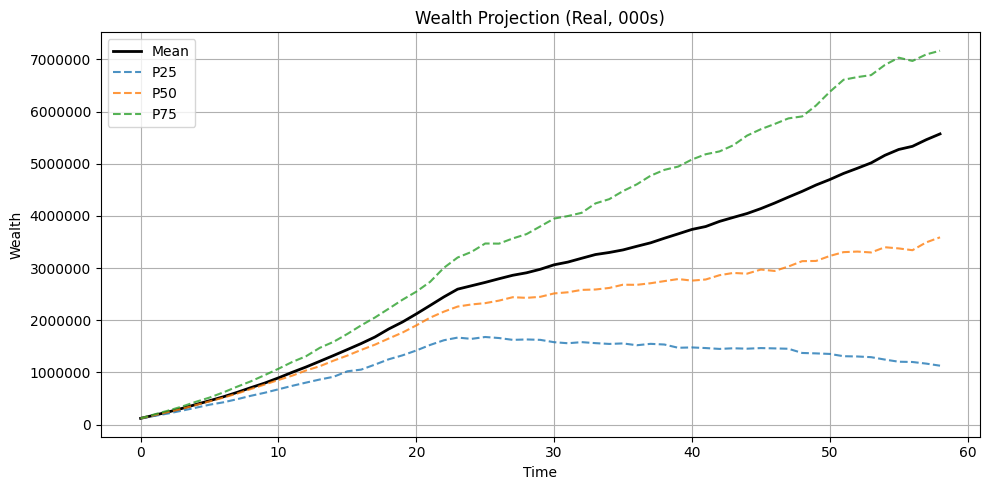

In [9]:
import matplotlib.pyplot as plt

def plot_simulation_series(result, use_real=True, percentiles=(25, 50, 75)):
    data = result.real if use_real else result.nominal
    x = result.timesteps
    plt.figure(figsize=(10, 5))

    plt.plot(x, data.mean, label="Mean", color="black", linewidth=2)

    for p in percentiles:
        y = data.percentiles.get(p) or data.percentiles.get(float(p))
        if y:
            plt.plot(x, y, label=f"P{int(p)}", linestyle="--", alpha=0.8)
    
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.xlabel("Time")
    plt.ylabel("Wealth")
    plt.title(f"Wealth Projection ({'Real, 000s' if use_real else 'Nominal, 000s'})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_simulation_series(result)

In [ ]:
percentiles = result.real.percentiles 

In [8]:
result.destitution

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003,
 0.004,
 0.005,
 0.008,
 0.011,
 0.013,
 0.016,
 0.018,
 0.024,
 0.028,
 0.033,
 0.037,
 0.041,
 0.046,
 0.054,
 0.057,
 0.062,
 0.067,
 0.073,
 0.081,
 0.086,
 0.096,
 0.1,
 0.109]

In [6]:
import numpy as np
from scipy.optimize import minimize
import datetime
from dateutil.relativedelta import relativedelta

# Pull your app types/services
from schemas.base_schemas import Profile, RecurringCashFlow, AdviserConfig
from services.simulation_service import SimulationService
from simulation_engine.common.types import SimulationPortfolioWeights

# Reproducibility (common random numbers idea if you add local randomness)
np.random.seed(42)


In [7]:
# Prepare inputs (assumes profile, cash_flows, adviser_config already exist)

plan_start_date = datetime.date.today()
plan_end_date = plan_start_date + relativedelta(years=int(profile.plan_end_age) - int(profile.age))
n_years = plan_end_date.year - plan_start_date.year

print("Years in plan:", n_years)


Years in plan: 58


In [26]:
# Initial glide path (linear 90% -> 30%)
initial_allocations = np.linspace(0.9, 0.3, n_years)
initial_allocations = np.clip(initial_allocations, 0.0, 1.0)
initial_allocations


array([0.9       , 0.88947368, 0.87894737, 0.86842105, 0.85789474,
       0.84736842, 0.83684211, 0.82631579, 0.81578947, 0.80526316,
       0.79473684, 0.78421053, 0.77368421, 0.76315789, 0.75263158,
       0.74210526, 0.73157895, 0.72105263, 0.71052632, 0.7       ,
       0.68947368, 0.67894737, 0.66842105, 0.65789474, 0.64736842,
       0.63684211, 0.62631579, 0.61578947, 0.60526316, 0.59473684,
       0.58421053, 0.57368421, 0.56315789, 0.55263158, 0.54210526,
       0.53157895, 0.52105263, 0.51052632, 0.5       , 0.48947368,
       0.47894737, 0.46842105, 0.45789474, 0.44736842, 0.43684211,
       0.42631579, 0.41578947, 0.40526316, 0.39473684, 0.38421053,
       0.37368421, 0.36315789, 0.35263158, 0.34210526, 0.33157895,
       0.32105263, 0.31052632, 0.3       ])

In [27]:
# Projections: monotone non-increasing and smoothness

def project_monotone_decreasing(a: np.ndarray) -> np.ndarray:
    a = a.copy()
    for i in range(1, len(a)):
        if a[i] > a[i-1]:
            a[i] = a[i-1]
    return a


def project_smooth(a: np.ndarray, max_change=0.15) -> np.ndarray:
    a = a.copy()
    for i in range(1, len(a)):
        diff = a[i] - a[i-1]
        if abs(diff) > max_change:
            a[i] = a[i-1] + np.sign(diff) * max_change
    return a


def project_allocations(a: np.ndarray, max_change=0.15) -> np.ndarray:
    a = np.clip(a, 0.0, 1.0)
    a = project_monotone_decreasing(a)
    a = project_smooth(a, max_change=max_change)
    a = np.clip(a, 0.0, 1.0)
    return a

projected = project_allocations(initial_allocations, max_change=0.15)
projected


array([0.9       , 0.88947368, 0.87894737, 0.86842105, 0.85789474,
       0.84736842, 0.83684211, 0.82631579, 0.81578947, 0.80526316,
       0.79473684, 0.78421053, 0.77368421, 0.76315789, 0.75263158,
       0.74210526, 0.73157895, 0.72105263, 0.71052632, 0.7       ,
       0.68947368, 0.67894737, 0.66842105, 0.65789474, 0.64736842,
       0.63684211, 0.62631579, 0.61578947, 0.60526316, 0.59473684,
       0.58421053, 0.57368421, 0.56315789, 0.55263158, 0.54210526,
       0.53157895, 0.52105263, 0.51052632, 0.5       , 0.48947368,
       0.47894737, 0.46842105, 0.45789474, 0.44736842, 0.43684211,
       0.42631579, 0.41578947, 0.40526316, 0.39473684, 0.38421053,
       0.37368421, 0.36315789, 0.35263158, 0.34210526, 0.33157895,
       0.32105263, 0.31052632, 0.3       ])

In [28]:
# Run simulation with custom allocations (override weights)

def run_simulation_with_allocations(allocations: np.ndarray, num_sims: int = None):
    ac = adviser_config
    if num_sims is not None:
        ac = adviser_config.model_copy()
        ac.number_of_simulations = int(num_sims)

    sim = SimulationService(profile=profile, cash_flows=cash_flows, adviser_config=ac)

    def custom_build_weights(plan_start_year: int, plan_end_year: int):
        weights = []
        for i, stock_alloc in enumerate(allocations):
            weights.append(SimulationPortfolioWeights(
                step=float(i),
                stocks=float(stock_alloc),
                bonds=float(1.0 - stock_alloc)
            ))
        return weights

    original_build_weights = sim._build_weights
    sim._build_weights = custom_build_weights
    try:
        result = sim.simulate()
    finally:
        sim._build_weights = original_build_weights

    return result


In [29]:
# Objective (survival proxy) and penalties

TARGET_END_VALUE = 0.0

def survival_probability_from_result(result) -> float:
    pcts = result.nominal.percentiles
    final_median = pcts.get(50.0, [result.nominal.final_median])[-1]
    score = 1.0 / (1.0 + np.exp(-(final_median - TARGET_END_VALUE) / max(1.0, abs(TARGET_END_VALUE) + 1.0)))
    return float(score)


def smoothness_penalty(a: np.ndarray, max_change=0.15):
    diffs = np.abs(np.diff(a))
    excess = np.clip(diffs - max_change, 0.0, None)
    return 50.0 * float(np.sum(excess))


def monotonicity_penalty(a: np.ndarray):
    inc = np.clip(np.diff(a), 0.0, None)
    return 200.0 * float(np.sum(inc))

def destitution_metric_from_result(result) -> float:
    return float(result.destitution_area)


def objective(a_cont: np.ndarray, inner_sims=300):
    a = project_allocations(a_cont, max_change=0.15)
    result = run_simulation_with_allocations(a, num_sims=inner_sims)

    destitution = destitution_metric_from_result(result)

    penalty = smoothness_penalty(a, max_change=0.15) + monotonicity_penalty(a)
    
    return destitution + penalty


In [30]:
# Optimize with SLSQP (project inside objective)

bounds = [(0.0, 1.0) for _ in range(n_years)]

# print("Initial objective:", objective(projected, inner_sims=300))

res = minimize(
    fun=lambda x: objective(x, inner_sims=300),
    x0=projected,
    method='SLSQP',
    bounds=bounds,
    options={'maxiter': 200, 'ftol': 1e-4, 'disp': True}
)

opt_continuous = project_allocations(res.x, max_change=0.15)


   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.615789  0.384211   0.0
28.0  0.605263  

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.023160919540229884
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.615789  0.384211   0.0
28.0  0.605263  0.394737   0.0
29.0  0.594737  0.405263   0.0
30.0  0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.615789  0.384211   0.0
28.0  0.605263  0.394737   0.0
29.0  0.594737  0.405263   0.0
30.0  0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.02517241379310345
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.019310344827586208
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.01781609195402299
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.61

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.01948275862068966
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.020574712643678158
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684  

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.01655172413793104
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.900000  0.100000   0.0
1.0   0.889474  0.110526   0.0
2.0   0.878947  0.121053   0.0
3.0   0.868421  0.131579   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847368  0.152632   0.0
6.0   0.836842  0.163158   0.0
7.0   0.826316  0.173684   0.0
8.0   0.815789  0.184211   0.0
9.0   0.805263  0.194737   0.0
10.0  0.794737  0.205263   0.0
11.0  0.784211  0.215789   0.0
12.0  0.773684  0.226316   0.0
13.0  0.763158  0.236842   0.0
14.0  0.752632  0.247368   0.0
15.0  0.742105  0.257895   0.0
16.0  0.731579  0.268421   0.0
17.0  0.721053  0.278947   0.0
18.0  0.710526  0.289474   0.0
19.0  0.700000  0.300000   0.0
20.0  0.689474  0.310526   0.0
21.0  0.678947  0.321053   0.0
22.0  0.668421  0.331579   0.0
23.0  0.657895  0.342105   0.0
24.0  0.647368  0.352632   0.0
25.0  0.636842  0.363158   0.0
26.0  0.626316  0.373684   0.0
27.0  0.61

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.014195402298850576
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
      stocks  bonds  cash
step                     
0.0      0.0    1.0   0.0
1.0      0.0    1.0   0.0
2.0      0.0    1.0   0.0
3.0      0.0    1.0   0.0
4.0      0.0    1.0   0.0
5.0      0.0    1.0   0.0
6.0      0.0    1.0   0.0
7.0      0.0    1.0   0.0
8.0      0.0    1.0   0.0
9.0      0.0    1.0   0.0
10.0     0.0    1.0   0.0
11.0     0.0    1.0   0.0
12.0     0.0    1.0   0.0
13.0     0.0    1.0   0.0
14.0     0.0    1.0   0.0
15.0     0.0    1.0   0.0
16.0     0.0    1.0   0.0
17.0     0.0    1.0   0.0
18.0     0.0    1.0   0.0
19.0     0.0    1.0   0.0
20.0     0.0    1.0   0.0
21.0     0.0    1.0   0.0
22.0     0.0    1.0   0.0
23.0     0.0    1.0   0.0
24.0     0.0    1.0   0.0
25.0     0.0    1.0   0.0
26.0     0.0    1.0   0.0
27.0     0.0    1.0   0.0
28.0     0.0    1.0   0.0
29.0     0.0    1.0   0.0
30.0     0.0    1.0   0.0
31.0     0.0    1.0   0.0
32.0     0.0    1.0   0.

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.018218390804597702
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.871875  0.128125   0.0
1.0   0.871875  0.128125   0.0
2.0   0.871875  0.128125   0.0
3.0   0.841283  0.158717   0.0
4.0   0.841283  0.158717   0.0
5.0   0.841283  0.158717   0.0
6.0   0.841283  0.158717   0.0
7.0   0.800493  0.199507   0.0
8.0   0.800493  0.199507   0.0
9.0   0.780099  0.219901   0.0
10.0  0.769901  0.230099   0.0
11.0  0.769901  0.230099   0.0
12.0  0.749507  0.250493   0.0
13.0  0.749507  0.250493   0.0
14.0  0.729112  0.270888   0.0
15.0  0.729112  0.270888   0.0
16.0  0.708717  0.291283   0.0
17.0  0.698520  0.301480   0.0
18.0  0.698520  0.301480   0.0
19.0  0.698520  0.301480   0.0
20.0  0.698520  0.301480   0.0
21.0  0.657730  0.342270   0.0
22.0  0.657730  0.342270   0.0
23.0  0.637336  0.362664   0.0
24.0  0.627138  0.372862   0.0
25.0  0.616941  0.383059   0.0
26.0  0.616941  0.383059   0.0
27.0  0.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.01609195402298851
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319   

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.013793103448275864
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319  

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.027988505747126437
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319  

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.011954022988505748
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319  

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.019597701149425287
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319   0.0
27.0  0.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.028505747126436786
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319   0.0
27.0  0.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

destitution area 0.024540229885057475
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319   0.0
27.0  0.6

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

Simulating...
destitution area 0.02505747126436782
   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319   

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill i

In [31]:
# High-accuracy evaluation and practical rounding

def round_practical(a: np.ndarray, step=0.1):
    r = np.round(a / step) * step
    r = np.clip(r, 0.0, 1.0)
    for i in range(1, len(r)):
        if r[i] > r[i-1]:
            r[i] = r[i-1]
    return r

# Evaluate optimized path with higher N
eval_result = run_simulation_with_allocations(opt_continuous, num_sims=2000)
eval_destitution = destitution_metric_from_result(eval_result)
print("Optimized destitution (area):", round(eval_destitution, 6))

# Practical rounding to 10%
opt_practical = round_practical(opt_continuous, step=0.1)
practical_result = run_simulation_with_allocations(opt_practical, num_sims=2000)
practical_destitution = destitution_metric_from_result(practical_result)
print("Practical destitution (area, rounded 10%):", round(practical_destitution, 6))

opt_practical

   step  cashflow
0   0.0   53000.0
1  24.0  -54000.0
        stocks     bonds  cash
step                          
0.0   0.899121  0.100879   0.0
1.0   0.889582  0.110418   0.0
2.0   0.879066  0.120934   0.0
3.0   0.867573  0.132427   0.0
4.0   0.857895  0.142105   0.0
5.0   0.847517  0.152483   0.0
6.0   0.837001  0.162999   0.0
7.0   0.825509  0.174491   0.0
8.0   0.815969  0.184031   0.0
9.0   0.804477  0.195523   0.0
10.0  0.793961  0.206039   0.0
11.0  0.784421  0.215579   0.0
12.0  0.772929  0.227071   0.0
13.0  0.763389  0.236611   0.0
14.0  0.751897  0.248103   0.0
15.0  0.742357  0.257643   0.0
16.0  0.730865  0.269135   0.0
17.0  0.720348  0.279652   0.0
18.0  0.710809  0.289191   0.0
19.0  0.700293  0.299707   0.0
20.0  0.689777  0.310223   0.0
21.0  0.678284  0.321716   0.0
22.0  0.668745  0.331255   0.0
23.0  0.657252  0.342748   0.0
24.0  0.646736  0.353264   0.0
25.0  0.636220  0.363780   0.0
26.0  0.626681  0.373319   0.0
27.0  0.616165  0.383835   0.0
28.0  0.604672  

c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)
c:\Users\olive\Documents\AdviceTools\AdviceTools\simulation_engine\commands.py:90: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  base_sim_data["transactions"] = base_sim_data["transactions"].fillna(0)


array([0.9, 0.9, 0.9, 0.9, 0.9, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8,
       0.8, 0.8, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.7, 0.6, 0.6,
       0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4,
       0.4, 0.3, 0.3, 0.3, 0.3, 0.3])

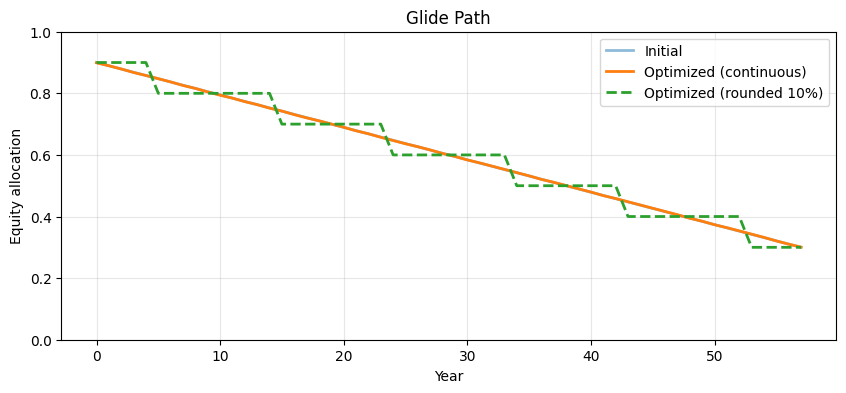

Optimized destitution (area): 0.022379
Practical destitution (area, rounded 10%): 0.017828


In [32]:
# Optional visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(initial_allocations, label="Initial", lw=2, alpha=0.5)
plt.plot(opt_continuous, label="Optimized (continuous)", lw=2)
plt.plot(opt_practical, label="Optimized (rounded 10%)", lw=2, linestyle='--')
plt.ylim(0, 1.0)
plt.title("Glide Path")
plt.xlabel("Year")
plt.ylabel("Equity allocation")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print destitution under the plot
try:
    print(f"Optimized destitution (area): {eval_destitution:.6f}")
    print(f"Practical destitution (area, rounded 10%): {practical_destitution:.6f}")
except NameError:
    pass
